# Lab Besos Work Flow from idf to surrogate desgin optimization


In this laboratory you will go over some of the basic work flow to create a a surrogate design optimization model from an EnergyPlus simulation. You will train a surrogate model network to find optimal design parameters.

In [1]:
#!pip install besos --user
%matplotlib inline
import time
import numpy as np
import pandas as pd

from besos import eppy_funcs as ef
from besos import sampling
from besos.evaluator import EvaluatorEP, EvaluatorGeneric
from besos.parameters import RangeParameter, FieldSelector, Parameter
from besos.problem import EPProblem, Problem
from besos import eppy_funcs as ef, sampling
from besos.optimizer import NSGAII

from epw import epw

import matplotlib.pyplot as plt
from seaborn import heatmap
from seaborn import pairplot
from plotly import express as px
import plotly

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.metrics import mean_squared_error, r2_score

import plotly
import plotly.express as px

2025-12-11 14:04:51.018739: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2025-12-11 14:04:51.018986: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Couldn't import dot_parser, loading of dot files will not be possible.


# Building presentation

In this Laboratory you will have to perform a surrogate optimization of a sample residential building unit. The considered unit is composed by a typical flat of a multi-storey building. Its internal organisation and definition is in line with suggested residential building typologies included in well-known architectural technical manuals  The considered building is composed by two units for floor, while a single unit is simulated for this chapter. The simulated spaces are considered to be at an intermediate floor with an upper floor and lower floor working at the same temperature (adiabatic). Similarly, the simulated unit is touching a specular one: confining walls are also assumed as adiabatic. Upper-floor balconies are included to consider shading effects.

![Image](image/building_lab.png)

## Load the Building 

The building is defined by the Information Data File (IDF) or using the new EnergyPlus format (IDF).

In [2]:
# Open the IDF file
idf_file = 'Res-Flat2_IDF_9.6_modified.idf'
building = ef.get_building(idf_file)

#building.view_model()

## Evaluator
## Set up the inputs and outputs of your exploration

- what properties of the building will we be changing?
- what are some of the performance metrics of the building that we want to explore?
- what external weather conditions is the building experiencing?


![Image](image/setting_up_the_evaluator.PNG)

### Load and Display Weather Data

In [3]:
# The weather conditions are specified in the EnergyPlus Weather File (EWP) file. The properties we will change in the building will be defined in the parameter space. In the objectives we will specify the what output performance metrics we wish to extract such that we can explore them later.

weather_data = epw()
epw_file = "PARIS_FR-hour.epw"
weather_data.read(epw_file)

weather_data.dataframe

Year  Month  Day  Hour  Minute  \
0     2005      1    1     1      60   
1     2005      1    1     2      60   
2     2005      1    1     3      60   
3     2005      1    1     4      60   
4     2005      1    1     5      60   
...    ...    ...  ...   ...     ...   
8755  2005     12   31    20      60   
8756  2005     12   31    21      60   
8757  2005     12   31    22      60   
8758  2005     12   31    23      60   
8759  2005     12   31    24      60   

                 Data Source and Uncertainty Flags  Dry Bulb Temperature  \
0     *?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?                   0.2   
1     *?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?                  -0.2   
2     *?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?                  -0.6   
3     *?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?                  -0.8   
4     *?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?                  -1.1   
...                                            ...                   ...   
8755  *?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?                   1.2   
8756  *?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?                   0.9   
8757  *?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?                   0.6   
8758  *?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?                   0.1   
8759  *?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?                   0.1   

      Dew Point Temperature  Relative Humidity  Atmospheric Station Pressure  \
0                      -7.4                 56                        101164   
1                      -7.4                 58                        101164   
2                      -7.9                 57                        101164   
3                      -8.1                 58                        101164   
4                      -8.4                 57                        101164   
...                     ...                ...                           ...   
8755                   -1.7                 81                        100678   
8756                   -2.1                 80                        100689   
8757                   -2.9                 77                        100700   
8758                   -1.7                 88                        100711   
8759                   -1.5                 89                        100722   

      ...  Ceiling Height  Present Weather Observation  Present Weather Codes  \
0     ...           99999                            9              999999999   
1     ...           99999                            9              999999999   
2     ...           99999                            9              999999999   
3     ...           99999                            9              999999999   
4     ...           99999                            9              999999999   
...   ...             ...                          ...                    ...   
8755  ...           99999                            9              999999999   
8756  ...           99999                            9              999999999   
8757  ...           99999                            9              999999999   
8758  ...           99999                            9              999999999   
8759  ...           99999                            9              999999999   

      Precipitable Water  Aerosol Optical Depth  Snow Depth  \
0                      6                  0.094           1   
1                      6                  0.094           1   
2                      5                  0.094           1   
3                      5                  0.094           1   
4                      5                  0.094           1   
...                  ...                    ...         ...   
8755                   8                  0.101           0   
8756                   8                  0.101           0   
8757                   8                  0.101           0   
8758                   8                  0.101 

In [4]:
weather_data.dataframe.describe()

Year        Month          Day         Hour  Minute  \
count  8760.0  8760.000000  8760.000000  8760.000000  8760.0   
mean   2005.0     6.526027    15.720548    12.500000    60.0   
std       0.0     3.448048     8.796749     6.922582     0.0   
min    2005.0     1.000000     1.000000     1.000000    60.0   
25%    2005.0     4.000000     8.000000     6.750000    60.0   
50%    2005.0     7.000000    16.000000    12.500000    60.0   
75%    2005.0    10.000000    23.000000    18.250000    60.0   
max    2005.0    12.000000    31.000000    24.000000    60.0   

       Dry Bulb Temperature  Dew Point Temperature  Relative Humidity  \
count           8760.000000            8760.000000        8760.000000   
mean              13.459167               7.302180          67.973630   
std                6.417562               5.387262          14.378834   
min               -1.900000              -8.800000          27.000000   
25%                8.700000               3.500000          57.000000   
50%               13.200000               7.400000          68.000000   
75%               18.300000              11.200000          79.000000   
max               33.200000              22.800000         100.000000   

       Atmospheric Station Pressure  Extraterrestrial Horizontal Radiation  \
count                   8760.000000                            8760.000000   
mean                  100858.916324                             289.739269   
std                      272.243386                             374.530939   
min                   100069.000000                               0.000000   
25%                   100661.000000                               0.000000   
50%                   100849.000000                              16.000000   
75%                   101066.000000                             546.000000   
max                   101547.000000                            1190.000000   

       ...  Ceiling Height  Present Weather Observation  \
count  ...          8760.0                       8760.0   
mean   ...         99999.0                          9.0   
std    ...             0.0                          0.0   
min    ...         99999.0                          9.0   
25%    ...         99999.0                          9.0   
50%    ...         99999.0                          9.0   
75%    ...         99999.0                          9.0   
max    ...         99999.0                          9.0   

       Present Weather Codes  Precipitable Water  Aerosol Optical Depth  \
count                 8760.0         8760.000000            8760.000000   
mean             999999999.0           16.600685               0.174258   
std                      0.0            6.329907               0.060578   
min              999999999.0            5.000000               0.039000   
25%              999999999.0           12.000000               0.126000   
50%              999999999.0           16.000000               0.181000   
75%              999999999.0           20.000000               0.218000   
max              999999999.0           46.000000               0.338000   

        Snow Depth  Days Since Last Snowfall       Albedo  \
count  8760.000000               8760.000000  8760.000000   
mean      0.015183                 74.213014     0.201285   
std       0.184135                 26.073199     0.017504   
min       0.000000                  0.000000     0.200000   
25%       0.000000                 76.000000     0.200000   
50%       0.000000                 88.000000     0.200000   
75%       0.000000                 88.000000     0.200000   
max       3.000000                 88.000000     0.607000   

       Liquid Precipitation Depth  Liquid Precipitation Quantity  
count                 8760.000000                         8760.0  
mean                     0.051541                           99.0  
std                      0.314345                            0.0  
min                      0.000000            

# Define The Problem

1. Define the parameters and your objectives you whant to change
2. Create Selectors for getting the parameters fileds in the model
3. Describe the parameter variation
4. Define your problem

- Print the elements we want to optimize

In [5]:
building.idfobjects['MATERIAL']

[
Material,
    Cast Concrete (Dense)_.1,    !- Name
    Rough,                    !- Roughness
    0.1,                      !- Thickness
    1.4,                      !- Conductivity
    2100,                     !- Density
    840,                      !- Specific Heat
    0.9,                      !- Thermal Absorptance
    0.6,                      !- Solar Absorptance
    0.6;                      !- Visible Absorptance
, 
Material,
    Asphalt 1_.01,            !- Name
    Rough,                    !- Roughness
    0.01,                     !- Thickness
    0.7,                      !- Conductivity
    2100,                     !- Density
    1000,                     !- Specific Heat
    0.9,                      !- Thermal Absorptance
    0.85,                     !- Solar Absorptance
    0.9;                      !- Visible Absorptance
, 
Material,
    MW Glass Wool (rolls)_.0001,    !- Name
    Rough,                    !- Roughness
    0.0001,                   !- Thickness

In [6]:
for elm in building.idfobjects['FENESTRATIONSURFACE:DETAILED']:
    # there are doors, so filter them to extract the windows
    if elm.Surface_Type == 'Window':
        print(elm)


FenestrationSurface:Detailed,
    StairXnoHVAC:Zona1_Wall_2_0_0_0_0_0_Win,    !- Name
    Window,                   !- Surface Type
    simple_glazing_window,    !- Construction Name
    StairXnoHVAC:Zona1_Wall_2_0_0,    !- Building Surface Name
    ,                         !- Outside Boundary Condition Object
    AutoCalculate,            !- View Factor to Ground
    1,                        !- Frame and Divider Name
    1,                        !- Multiplier
    4,                        !- Number of Vertices
    3.5,                      !- Vertex 1 Xcoordinate
    5.615,                    !- Vertex 1 Ycoordinate
    0.84,                     !- Vertex 1 Zcoordinate
    3.5,                      !- Vertex 2 Xcoordinate
    6.135,                    !- Vertex 2 Ycoordinate
    0.84,                     !- Vertex 2 Zcoordinate
    3.5,                      !- Vertex 3 Xcoordinate
    6.135,                    !- Vertex 3 Ycoordinate
    2.26,                     !- Vertex 3 Zcoor

In [7]:
building.idfobjects["WINDOWSHADINGCONTROL"]

[
WindowShadingControl,
    11001,                    !- Name
    StairXnoHVAC:Zona1,       !- Zone Name
    ,                         !- Shading Control Sequence Number
    ExteriorBlind,            !- Shading Type
    simple_glazing_window_with_blind,    !- Construction with Shading Name
    OnIfHighOutdoorAirTempAndHighHorizontalSolar,    !- Shading Control Type
    Summer (Northern Hemisphere),    !- Schedule Name
    24,                       !- Setpoint
    Yes,                      !- Shading Control Is Scheduled
    No,                       !- Glare Control Is Active
    20002,                    !- Shading Device Material Name
    FixedSlatAngle,           !- Type of Slat Angle Control for Blinds
    ,                         !- Slat Angle Schedule Name
    120,                      !- Setpoint 2
    ,                         !- Daylighting Control Object Name
    Group,                    !- Multiple Surface Control Type
    StairXnoHVAC:Zona1_Wall_2_0_0_0_0_0_Win;    !- Fen

In [8]:
building.idfobjects['ZONEVENTILATION:DESIGNFLOWRATE']

[
ZoneVentilation:DesignFlowRate,
    Flat2:Zona3 Nat Vent,     !- Name
    Flat2:Zona3,              !- Zone or ZoneList Name
    Summer (Northern Hemisphere),    !- Schedule Name
    AirChanges/Hour,          !- Design Flow Rate Calculation Method
    0.016649,                 !- Design Flow Rate
    ,                         !- Flow Rate per Zone Floor Area
    ,                         !- Flow Rate per Person
    1,                        !- Air Changes per Hour
    NATURAL,                  !- Ventilation Type
    0,                        !- Fan Pressure Rise
    1,                        !- Fan Total Efficiency
    1,                        !- Constant Term Coefficient
    0,                        !- Temperature Term Coefficient
    0,                        !- Velocity Term Coefficient
    0,                        !- Velocity Squared Term Coefficient
    18,                       !- Minimum Indoor Temperature
    ,                         !- Minimum Indoor Temperature Schedul

- Create FieldSelectors and Parameters

In [9]:
parameters = []

# 1) Thermal insulation thickness - walls
insulation_wall_selector = FieldSelector(class_name='Material', object_name='_Insulation_.0001', field_name='Thickness')
wall_range = RangeParameter(min_val=0.01, max_val=0.25)

insulation_wall_param = Parameter(
    selector=insulation_wall_selector,
    value_descriptor=wall_range,
    name='Insulation Wall Thickness'
)

parameters.append(insulation_wall_param)

/opt/conda/envs/myenv/lib/python3.9/site-packages/besos/parameters.py:424: FutureWarning: Use value_descriptors instead of value_descriptor.
  warnings.warn(


In [10]:
# 2) Thermal insulation thickness - roofs
insulation_roof_selector = FieldSelector(class_name='Material', object_name='MW Glass Wool (rolls)_.0001', field_name='Thickness')
roof_range = RangeParameter(min_val=0.01, max_val=0.50)

insulation_roof_param = Parameter(
    selector=insulation_roof_selector,
    value_descriptor=roof_range,
    name='Insulation Roof Thickness'
)

parameters.append(insulation_roof_param)

In [11]:
# 3) Window types: U-Factor, SHGC and VT

# - U-Factor (Glazing Heat Loss)
# Range from 0.8 (triple pane/high performance) to 5.0 (single pane)
u_factor_range = RangeParameter(min_val=0.8, max_val=5.0)
u_factor_selector = FieldSelector(
    class_name='WindowMaterial:SimpleGlazingSystem',
    object_name='*',
    field_name='U-Factor'
)
u_factor_param = Parameter(
    selector=u_factor_selector,
    value_descriptors=u_factor_range,
    name='Glazing - U-Factor (W/m2-K)'
)

parameters.append(u_factor_param)

# - Solar Heat Gain Coefficient (SHGC)
# Range from 0.3 (low solar gain) to 0.8 (high solar gain)
shgc_range = RangeParameter(min_val=0.3, max_val=0.8)
shgc_selector = FieldSelector(
    class_name='WindowMaterial:SimpleGlazingSystem',
    object_name='*',
    field_name='Solar Heat Gain Coefficient'
)
shgc_param = Parameter(
    selector=shgc_selector,
    value_descriptors=shgc_range,
    name='Glazing - SHGC'
)

parameters.append(shgc_param)

# Visible Transmittance (VT)
# Range from 0.3 to 0.8
visible_transmittance_range = RangeParameter(min_val=0.3, max_val=0.8)
visible_transmittance_selector = FieldSelector(
    class_name='WindowMaterial:SimpleGlazingSystem',
    object_name='*',
    field_name='Visible Transmittance'
)
visible_transmittance_param = Parameter(
    selector=visible_transmittance_selector,
    value_descriptors=visible_transmittance_range,
    name='Glazing - Visible Transmittance'
)

parameters.append(visible_transmittance_param)

In [12]:
# 4) Shading thresholds: temperature + global horizontal irradiation

# - temperature
TempShadingRange = RangeParameter(min_val=18, max_val=30)
shade_temp_selector = FieldSelector(
    class_name='WindowShadingControl',
    object_name='*',
    field_name='Setpoint'
)
shade_temp_param = Parameter(
    selector=shade_temp_selector,
    value_descriptor=TempShadingRange,
    name='Temp Setpoint shading'
)
parameters.append(shade_temp_param)

# - global horizontal irradiation
RadShadingRange = RangeParameter(min_val=80, max_val=300)
shade_rad_selector = FieldSelector(
    class_name='WindowShadingControl',
    object_name='*',
    field_name='Setpoint 2'
)
shade_rad_param = Parameter(
    selector=shade_rad_selector,
    value_descriptor=RadShadingRange,
    name='Rad Setpoint shading'
)
parameters.append(shade_rad_param)

In [13]:
# 5) Natural ventilation thresholds: Tin.Min, Tin. Max 

TinMinRange = RangeParameter(min_val=10.0, max_val=20.0)
TinMaxRange = RangeParameter(min_val=15.0, max_val=35.0)

# - Tin. Min (Minimum Indoor Temperature)
vent_tin_min_selector = FieldSelector(
    class_name = 'ZoneVentilation:DesignFlowRate',
    object_name = '*',
    field_name = 'Minimum Indoor Temperature'
)
vent_tin_min_param = Parameter(
    selector=vent_tin_min_selector, 
    value_descriptor=TinMinRange,
    name='Ventilation Min Tin Threshold'
)
parameters.append(vent_tin_min_param)

# - Tin. Max (Maximum Indoor Temperature)
vent_tin_max_selector = FieldSelector(
    class_name = 'ZoneVentilation:DesignFlowRate',
    object_name = '*',
    field_name = 'Maximum Indoor Temperature'
)
vent_tin_max_param = Parameter(
    selector=vent_tin_max_selector, 
    value_descriptor=TinMaxRange,
    name='Ventilation Max Tin Threshold'
)
parameters.append(vent_tin_max_param)

In [14]:
# 6) Natural ventilation ACH (Air Changes per Hour)
ventAchRange = RangeParameter(min_val=0.0, max_val=6.0)

ventACH_selector = FieldSelector(
    class_name = 'ZoneVentilation:DesignFlowRate',
    object_name = '*',
    field_name = 'Air Changes per Hour'
)
ventilationACH_param = Parameter(
    selector=ventACH_selector, 
    value_descriptors=ventAchRange,
    name='Ventilation ACH'
)

parameters.append(ventilationACH_param)

In [15]:
# 7) Lighting intensity
lights_range = RangeParameter(min_val=2, max_val=6)

lights_selector = FieldSelector(
    class_name='Lights',
    object_name='*',
    field_name='Watts per Zone Floor Area'
)

lights_param = Parameter(
    lights_selector,
    value_descriptors=lights_range,
    name="Lights Watts/Area"
)
parameters.append(lights_param)

In [16]:
# Print parameters
print("\nAll parameters:")
for i in range(len(parameters)):
    print(f" {i}) {parameters[i].name}")


All parameters:
 0) Insulation Wall Thickness
 1) Insulation Roof Thickness
 2) Glazing - U-Factor (W/m2-K)
 3) Glazing - SHGC
 4) Glazing - Visible Transmittance
 5) Temp Setpoint shading
 6) Rad Setpoint shading
 7) Ventilation Min Tin Threshold
 8) Ventilation Max Tin Threshold
 9) Ventilation ACH
 10) Lights Watts/Area


/tmp/ipykernel_40/2951783100.py:4: DeprecationWarning: Call to deprecated function (or staticmethod) name. (Parameters are no longer nameable. Use the name(s) of this Parameter's Descriptor(s) instead) -- Deprecated since version 2.0.0.
  print(f" {i}) {parameters[i].name}")


- Define the problem

In [17]:
objectives = [
    'Electricity:Facility', # light inside
    'DistrictHeating:Facility',
    'DistrictCooling:Facility'
] # these get made into `MeterReader` or `VariableReader`
# cannot sum them -> NEVER sum it

problem = EPProblem(parameters, objectives) # problem = parameters + objectives

problem.names()

['Insulation Wall Thickness',
 'Insulation Roof Thickness',
 'Glazing - U-Factor (W/m2-K)',
 'Glazing - SHGC',
 'Glazing - Visible Transmittance',
 'Temp Setpoint shading',
 'Rad Setpoint shading',
 'Ventilation Min Tin Threshold',
 'Ventilation Max Tin Threshold',
 'Ventilation ACH',
 'Lights Watts/Area',
 'Electricity:Facility',
 'DistrictHeating:Facility',
 'DistrictCooling:Facility']

## Generate the Dataset

1. Generate 20 samples with sampling strategy
2. Setup the parallel processing
3. Simulate the Samples
4. Store and recover the expensive runs

In [18]:
number_of_samples = 40 # can increase it if we have dependency issues
samples = sampling.dist_sampler(sampling.lhs, problem, num_samples=number_of_samples)
samples

Insulation Wall Thickness  Insulation Roof Thickness  \
0                    0.096259                   0.185555   
1                    0.206224                   0.011653   
2                    0.131605                   0.177125   
3                    0.170237                   0.404082   
4                    0.223101                   0.129630   
5                    0.076962                   0.221788   
6                    0.186439                   0.386582   
7                    0.143748                   0.084199   
8                    0.190761                   0.472113   
9                    0.022082                   0.071227   
10                   0.138370                   0.462749   
11                   0.148635                   0.194650   
12                   0.016464                   0.441336   
13                   0.042164                   0.209187   
14                   0.066134                   0.098603   
15                   0.038259                   0.112963   
16                   0.213495                   0.142212   
17                   0.110284                   0.482339   
18                   0.164396                   0.155774   
19                   0.198631                   0.257429   
20                   0.157254                   0.295366   
21                   0.061007                   0.489027   
22                   0.233951                   0.364659   
23                   0.070601                   0.249801   
24                   0.082217                   0.076498   
25                   0.102313                   0.415248   
26                   0.129665                   0.328963   
27                   0.051112                   0.233561   
28                   0.247297                   0.366367   
29                   0.028545                   0.267837   
30                   0.183338                   0.341156   
31                   0.088914                   0.287845   
32                   0.057920                   0.433503   
33                   0.241074                   0.166540   
34                   0.010484                   0.050447   
35                   0.230863                   0.396706   
36                   0.122590                   0.320309   
37                   0.113335                   0.313010   
38                   0.215752                   0.041482   
39                   0.172066                   0.030107   

    Glazing - U-Factor (W/m2-K)  Glazing - SHGC  \
0                      1.548554        0.610247   
1                      2.755570        0.615476   
2                      3.976791        0.508224   
3                      2.302448        0.691484   
4                      2.547491        0.630478   
5                      4.724824        0.763065   
6                      2.968193        0.750066   
7                      4.801022        0.560378   
8                      2.834566        0.660389   
9                      2.223043        0.735083   
10                     3.879012        0.314494   
11                     4.450395        0.746470   
12                     2.055562        0.467688   
13                     3.102640        0.596618   
14                     2.609656        0.664690   
15                     4.958534        0.350878   
16                     3.589525        0.789732   
17                     3.733777        0.713056   
18                     1.197820        0.437786   
19                     3.134383        0.431910   
20                     0.823753        0.416240   
21                     3.219283        0.308331   
22                     4.194865        0.475658   
23                     3.755860        0.405063   
24                     4.082418        0.517434   
25                     1.002175        0.390561   
26                     4.661645        0.785448   
27                     1.747674        0.458626   
28                     3.392243        0.687261   
29           

In [19]:
evaluator = EvaluatorEP(
    problem, 
    building, 
    out_dir='outputdir',
    err_dir='outputdir',
    epw_file=epw_file,
    progress_bar=True
)

/opt/conda/envs/myenv/lib/python3.9/site-packages/besos/evaluator.py:672: FutureWarning: epw_file has been deprecated and will be removed in the future. Use epw instead.
  warn(


Run the samples and calculate the execution time

In [20]:
# Run Energyplus
t1 = time.time()

sim_samples = evaluator.df_apply(
    samples,
    keep_input=True, # keep the input data in the results
    #keep_dirs=True, # save all ouput
    processes=2
)  

t2 = time.time()
time_of_sim = t2 - t1

EnergyPlus Starting
EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2025.12.11 14:05
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2025.12.11 14:05


Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]
Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Initializing Response Factors
Initializing Response Factors
Calculating CTFs for "PAVIMENTO INTERNO DI PROGETTO"
Calculating CTFs for "PAVIMENTO INTERNO DI PROGETTO"
Calculating CTFs for "_FLATROOF_MOD"
Calculating CTFs for "_FLATROOF_MOD"
Calculating CTFs for "_WALL_MOD"
Calculating CTFs for "_WALL_MOD"
Calculating CTFs for "PARETE SEMI-ESPOSTA DI PROGETTO"
Calculating CTFs for "_WALL_MOD"
Calculating CTFs for "115MM SINGLE LEAF BRICK (PLASTERED BOTH SIDES)"
Calculating CTFs for "PAVIMENTO CONTROTERRA DI PROGETTO"
Initializing Window Optical Properties
Calculating CTFs for "PARETE SEMI-ESPOSTA DI PROGETTO"
Calculating CTFs for "115MM SINGLE LEAF BRICK (PLASTERED BOTH SIDES)"
Calculating CTFs for "PAVIMENTO CONTROTERRA DI PROGETTO"
Initializing Solar Calculations
Initializing Window Optical Properties
Allocate Solar Module Arrays
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Zone and Enclosure Report Variables

EnergyPlus Completed Successfully.
EnergyPlus Completed Successfully.


Updating Shadowing Calculations, Start Date=12/27/2002
Updating Detailed Daylighting Factors, Start Date=12/27
Continuing Simulation at 12/27/2002 for SENZA TITOLO (01-01:31-12)
Writing tabular output file results using tab format.
Writing tabular output file results using HTML format.
EnergyPlus Run Time=00hr 00min 14.35sec


Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2025.12.11 14:07
Initializing Response Factors
Calculating CTFs for "PAVIMENTO INTERNO DI PROGETTO"
Calculating CTFs for "_FLATROOF_MOD"
Calculating CTFs for "_FLATROOF_MOD"
Calculating CTFs for "_WALL_MOD"
Calculating CTFs for "PARETE SEMI-ESPOSTA DI PROGETTO"
Calculating CTFs for "115MM SINGLE LEAF BRICK (PLASTERED BOTH SIDES)"
Calculating CTFs for "PAVIMENTO CONTROTERRA DI PROGETTO"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Setting up Surface Reporting Variables
Initializing Temperature and Flux Histories
Initializing Window Shading
Comp

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2025.12.11 14:07
Initializing Response Factors
Calculating CTFs for "PAVIMENTO INTERNO DI PROGETTO"
Calculating CTFs for "_FLATROOF_MOD"
Calculating CTFs for "_WALL_MOD"
Calculating CTFs for "PARETE SEMI-ESPOSTA DI PROGETTO"


Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Calculating CTFs for "115MM SINGLE LEAF BRICK (PLASTERED BOTH SIDES)"
Calculating CTFs for "PAVIMENTO CONTROTERRA DI PROGETTO"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Setting up Surface Reporting Variables
Initializing Temperature and Flux Histories
Initializing Window Shading
Computing Interior Absorption Factors
Computing Interior Diffuse Solar Absorption Factors
Initializing Solar Heat Gains
Initializing Internal Heat Gains
Initializing Interior Solar Distribution
Initializing Interior Convection Coefficients
Gathering Information for Predefined Reporting
Completed Initializing Surface Heat Balan

EnergyPlus Completed Successfully.


Updating Shadowing Calculations, Start Date=11/17/2002
Updating Detailed Daylighting Factors, Start Date=11/17
Continuing Simulation at 11/17/2002 for SENZA TITOLO (01-01:31-12)
Updating Shadowing Calculations, Start Date=12/07/2002
Updating Detailed Daylighting Factors, Start Date=12/07
Continuing Simulation at 12/07/2002 for SENZA TITOLO (01-01:31-12)
Updating Shadowing Calculations, Start Date=12/27/2002
Updating Detailed Daylighting Factors, Start Date=12/27
Continuing Simulation at 12/27/2002 for SENZA TITOLO (01-01:31-12)
Writing tabular output file results using tab format.
Writing tabular output file results using HTML format.
EnergyPlus Run Time=00hr 00min 11.73sec
EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2025.12.11 14:08
Initializing Response Factors
Calculating CTFs for "PAVIMENTO INTERNO DI PROGETTO"
Calculating CTFs for "_FLATROOF_MOD"
Calculating CTFs for "_FLATROOF_MOD"
Calculating CTFs for "_WALL_MOD"
Calculating CTFs for "PARETE SEMI-ESPOSTA DI PRO

Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Setting up Surface Reporting Variables
Initializing Temperature and Flux Histories
Initializing Window Shading
Computing Interior Absorption Factors
Computing Interior Diffuse Solar Absorption Factors
Initializing Solar Heat Gains
Initializing Internal Heat Gains
Initializing Interior Solar Distribution
Initializing Interior Convection Coefficients
Gathering Information for Predefined Reporting
Completed Initializing Surface Heat Balance
Calculate Outside Surface Heat Balance
Calculate Inside Surface Heat Balance
Calculate Air Heat Balance
Initializing HVAC
Warming up
Calculating Detailed Daylighting Factors, Start Date=06/15
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #1 SUMMER DESIGN DAY IN SENZA TITOLO (01-01:31-12) GI

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2025.12.11 14:09
Initializing Response Factors
Calculating CTFs for "PAVIMENTO INTERNO DI PROGETTO"
Calculating CTFs for "_FLATROOF_MOD"
Calculating CTFs for "_WALL_MOD"
Calculating CTFs for "PARETE SEMI-ESPOSTA DI PROGETTO"
Calculating CTFs for "115MM SINGLE LEAF BRICK (PLASTERED BOTH SIDES)"
Calculating CTFs for "PAVIMENTO CONTROTERRA DI PROGETTO"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Setting up Surface Reporting Variables
Initializing Temperature and Flux Histories
Initializing Window Shading
Computing Interior Absorption Factors
Com

Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #1 SUMMER DESIGN DAY IN SENZA TITOLO (01-01:31-12) GIU
Warming up
Calculating Detailed Daylighting Factors, Start Date=07/15
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #2 SUMMER DESIGN DAY IN SENZA TITOLO (01-01:31-12) LUG
Warming up
Calculating Detailed Daylighting Factors, Start Date=08/15
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #3 SUMMER DESIGN DAY IN SENZA TITOLO (01-01:31-12) AGO
Warming up
Calculating Detailed Daylighting Factors, Start Date=09/15
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Pe

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2025.12.11 14:10
Initializing Response Factors
Calculating CTFs for "PAVIMENTO INTERNO DI PROGETTO"
Calculating CTFs for "_FLATROOF_MOD"
Calculating CTFs for "_WALL_MOD"
Calculating CTFs for "PARETE SEMI-ESPOSTA DI PROGETTO"
Calculating CTFs for "115MM SINGLE LEAF BRICK (PLASTERED BOTH SIDES)"
Calculating CTFs for "PAVIMENTO CONTROTERRA DI PROGETTO"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Setting up Surface Reporting Variables
Initializing Temperature and Flux Histories
Initializing Window Shading
Computing Interior Absorption Factors
Com

Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #1 SUMMER DESIGN DAY IN SENZA TITOLO (01-01:31-12) GIU
Warming up
Calculating Detailed Daylighting Factors, Start Date=07/15
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #2 SUMMER DESIGN DAY IN SENZA TITOLO (01-01:31-12) LUG
Warming up
Calculating Detailed Daylighting Factors, Start Date=08/15
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #3 SUMMER DESIGN DAY IN SENZA TITOLO (01-01:31-12) AGO
Warming up
Calculating Detailed Daylighting Factors, Start Date=09/15
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2025.12.11 14:11
Initializing Response Factors
Calculating CTFs for "PAVIMENTO INTERNO DI PROGETTO"
Calculating CTFs for "_FLATROOF_MOD"
Calculating CTFs for "_FLATROOF_MOD"
Calculating CTFs for "_WALL_MOD"
Calculating CTFs for "_WALL_MOD"
Calculating CTFs for "PARETE SEMI-ESPOSTA DI PROGETTO"
Calculating CTFs for "115MM SINGLE LEAF BRICK (PLASTERED BOTH SIDES)"
Calculating CTFs for "PAVIMENTO CONTROTERRA DI PROGETTO"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Setting up Surface Reporting Variables
Initializing Temperature and Flux Histories

Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #1 SUMMER DESIGN DAY IN SENZA TITOLO (01-01:31-12) GIU
Warming up
Calculating Detailed Daylighting Factors, Start Date=07/15
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #2 SUMMER DESIGN DAY IN SENZA TITOLO (01-01:31-12) LUG
Warming up
Calculating Detailed Daylighting Factors, Start Date=08/15
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #3 SUMMER DESIGN DAY IN SENZA TITOLO (01-01:31-12) AGO
Warming up
Calculating Detailed Daylighting Factors, Start Date=09/15
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #4 SU

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2025.12.11 14:12
Initializing Response Factors
Calculating CTFs for "PAVIMENTO INTERNO DI PROGETTO"
Calculating CTFs for "_FLATROOF_MOD"
Calculating CTFs for "_WALL_MOD"
Calculating CTFs for "PARETE SEMI-ESPOSTA DI PROGETTO"
Calculating CTFs for "115MM SINGLE LEAF BRICK (PLASTERED BOTH SIDES)"
Calculating CTFs for "PAVIMENTO CONTROTERRA DI PROGETTO"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Setting up Surface Reporting Variables
Initializing Temperature and Flux Histories
Initializing Window Shading
Computing Interior Absorption Factors
Com

Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #1 SUMMER DESIGN DAY IN SENZA TITOLO (01-01:31-12) GIU
Warming up
Calculating Detailed Daylighting Factors, Start Date=07/15
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #2 SUMMER DESIGN DAY IN SENZA TITOLO (01-01:31-12) LUG
Warming up
Calculating Detailed Daylighting Factors, Start Date=08/15
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #3 SUMMER DESIGN DAY IN SENZA TITOLO (01-01:31-12) AGO
Warming up
Calculating Detailed Daylighting Factors, Start Date=09/15
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #4 SU

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2025.12.11 14:12
Initializing Response Factors
Calculating CTFs for "PAVIMENTO INTERNO DI PROGETTO"
Calculating CTFs for "_FLATROOF_MOD"
Calculating CTFs for "_WALL_MOD"
Calculating CTFs for "PARETE SEMI-ESPOSTA DI PROGETTO"
Calculating CTFs for "115MM SINGLE LEAF BRICK (PLASTERED BOTH SIDES)"
Calculating CTFs for "PAVIMENTO CONTROTERRA DI PROGETTO"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Setting up Surface Reporting Variables
Initializing Temperature and Flux Histories
Initializing Window Shading
Computing Interior Absorption Factors
Com

Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #1 SUMMER DESIGN DAY IN SENZA TITOLO (01-01:31-12) GIU
Warming up
Calculating Detailed Daylighting Factors, Start Date=07/15
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #2 SUMMER DESIGN DAY IN SENZA TITOLO (01-01:31-12) LUG
Warming up
Calculating Detailed Daylighting Factors, Start Date=08/15
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #3 SUMMER DESIGN DAY IN SENZA TITOLO (01-01:31-12) AGO
Warming up
Calculating Detailed Daylighting Factors, Start Date=09/15
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...fo

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2025.12.11 14:13
Initializing Response Factors
Calculating CTFs for "PAVIMENTO INTERNO DI PROGETTO"
Calculating CTFs for "_FLATROOF_MOD"
Calculating CTFs for "_FLATROOF_MOD"
Calculating CTFs for "_WALL_MOD"
Calculating CTFs for "PARETE SEMI-ESPOSTA DI PROGETTO"
Calculating CTFs for "115MM SINGLE LEAF BRICK (PLASTERED BOTH SIDES)"
Calculating CTFs for "PAVIMENTO CONTROTERRA DI PROGETTO"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Setting up Surface Reporting Variables
Initializing Temperature and Flux Histories
Initializing Window Shading
Comp

Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #1 SUMMER DESIGN DAY IN SENZA TITOLO (01-01:31-12) GIU
Warming up
Calculating Detailed Daylighting Factors, Start Date=07/15
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #2 SUMMER DESIGN DAY IN SENZA TITOLO (01-01:31-12) LUG
Warming up
Calculating Detailed Daylighting Factors, Start Date=08/15
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #3 SUMMER DESIGN DAY IN SENZA TITOLO (01-01:31-12) AGO
Warming up
Calculating Detailed Daylighting Factors, Start Date=09/15
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warmin

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2025.12.11 14:14
Initializing Response Factors
Calculating CTFs for "PAVIMENTO INTERNO DI PROGETTO"
Calculating CTFs for "_FLATROOF_MOD"
Calculating CTFs for "_WALL_MOD"
Calculating CTFs for "PARETE SEMI-ESPOSTA DI PROGETTO"
Calculating CTFs for "115MM SINGLE LEAF BRICK (PLASTERED BOTH SIDES)"
Calculating CTFs for "PAVIMENTO CONTROTERRA DI PROGETTO"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Setting up Surface Reporting Variables
Initializing Temperature and Flux Histories
Initializing Window Shading
Computing Interior Absorption Factors
Com

Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #1 SUMMER DESIGN DAY IN SENZA TITOLO (01-01:31-12) GIU
Warming up
Calculating Detailed Daylighting Factors, Start Date=07/15
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #2 SUMMER DESIGN DAY IN SENZA TITOLO (01-01:31-12) LUG
Warming up
Calculating Detailed Daylighting Factors, Start Date=08/15
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #3 SUMMER DESIGN DAY IN SENZA TITOLO (01-01:31-12) AGO
Warming up
Calculating Detailed Daylighting Factors, Start Date=09/15
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #4 SUMMER DESIGN DAY IN SENZA TITOLO (

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2025.12.11 14:15
Initializing Response Factors
Calculating CTFs for "PAVIMENTO INTERNO DI PROGETTO"
Calculating CTFs for "_FLATROOF_MOD"
Calculating CTFs for "_WALL_MOD"
Calculating CTFs for "PARETE SEMI-ESPOSTA DI PROGETTO"
Calculating CTFs for "115MM SINGLE LEAF BRICK (PLASTERED BOTH SIDES)"
Calculating CTFs for "PAVIMENTO CONTROTERRA DI PROGETTO"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Setting up Surface Reporting Variables
Initializing Temperature and Flux Histories
Initializing Window Shading
Computing Interior Absorption Factors
Com

Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #1 SUMMER DESIGN DAY IN SENZA TITOLO (01-01:31-12) GIU
Warming up
Calculating Detailed Daylighting Factors, Start Date=07/15
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #2 SUMMER DESIGN DAY IN SENZA TITOLO (01-01:31-12) LUG
Warming up
Calculating Detailed Daylighting Factors, Start Date=08/15
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #3 SUMMER DESIGN DAY IN SENZA TITOLO (01-01:31-12) AGO
Warming up
Calculating Detailed Daylighting Factors, Start Date=09/15
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #4 SUMMER DESIGN

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2025.12.11 14:16
Initializing Response Factors
Calculating CTFs for "PAVIMENTO INTERNO DI PROGETTO"
Calculating CTFs for "_FLATROOF_MOD"
Calculating CTFs for "_FLATROOF_MOD"
Calculating CTFs for "_WALL_MOD"
Calculating CTFs for "_WALL_MOD"
Calculating CTFs for "PARETE SEMI-ESPOSTA DI PROGETTO"
Calculating CTFs for "115MM SINGLE LEAF BRICK (PLASTERED BOTH SIDES)"
Calculating CTFs for "PAVIMENTO CONTROTERRA DI PROGETTO"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations


Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Initializing Surfaces
Initializing Outdoor environment for Surfaces
Setting up Surface Reporting Variables
Initializing Temperature and Flux Histories
Initializing Window Shading
Computing Interior Absorption Factors
Computing Interior Diffuse Solar Absorption Factors
Initializing Solar Heat Gains
Initializing Internal Heat Gains
Initializing Interior Solar Distribution
Initializing Interior Convection Coefficients
Gathering Information for Predefined Reporting
Completed Initializing Surface Heat Balance
Calculate Outside Surface Heat Balance
Calculate Inside Surface Heat Balance
Calculate Air Heat Balance
Initializing HVAC
Warming up
Calculating Detailed Daylighting Factors, Start Date=06/15
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #1 SUMMER DESIGN DAY IN SENZA TITOLO (01-01:31-12) GIU
Warming up
Calculating Detailed Daylighting Factors, Start Date=07/15
Warming

EnergyPlus Completed Successfully.


Updating Detailed Daylighting Factors, Start Date=12/27
Continuing Simulation at 12/27/2002 for SENZA TITOLO (01-01:31-12)
Writing tabular output file results using tab format.
Writing tabular output file results using HTML format.
EnergyPlus Run Time=00hr 00min 12.05sec
EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2025.12.11 14:17
Initializing Response Factors
Calculating CTFs for "PAVIMENTO INTERNO DI PROGETTO"
Calculating CTFs for "_FLATROOF_MOD"
Calculating CTFs for "_WALL_MOD"
Calculating CTFs for "PARETE SEMI-ESPOSTA DI PROGETTO"
Calculating CTFs for "115MM SINGLE LEAF BRICK (PLASTERED BOTH SIDES)"
Calculating CTFs for "PAVIMENTO CONTROTERRA DI PROGETTO"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Fact

Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #1 SUMMER DESIGN DAY IN SENZA TITOLO (01-01:31-12) GIU
Warming up
Calculating Detailed Daylighting Factors, Start Date=07/15
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #2 SUMMER DESIGN DAY IN SENZA TITOLO (01-01:31-12) LUG
Warming up
Calculating Detailed Daylighting Factors, Start Date=08/15
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #3 SUMMER DESIGN DAY IN SENZA TITOLO (01-01:31-12) AGO
Warming up
Calculating Detailed Daylighting Factors, Start Date=09/15
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warmin

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2025.12.11 14:17
Initializing Response Factors
Calculating CTFs for "PAVIMENTO INTERNO DI PROGETTO"
Calculating CTFs for "_FLATROOF_MOD"
Calculating CTFs for "_WALL_MOD"
Calculating CTFs for "PARETE SEMI-ESPOSTA DI PROGETTO"
Calculating CTFs for "115MM SINGLE LEAF BRICK (PLASTERED BOTH SIDES)"
Calculating CTFs for "PAVIMENTO CONTROTERRA DI PROGETTO"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Setting up Surface Reporting Variables
Initializing Temperature and Flux Histories
Initializing Window Shading
Computing Interior Absorption Factors
Com

Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #1 SUMMER DESIGN DAY IN SENZA TITOLO (01-01:31-12) GIU
Warming up
Calculating Detailed Daylighting Factors, Start Date=07/15
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #2 SUMMER DESIGN DAY IN SENZA TITOLO (01-01:31-12) LUG
Warming up
Calculating Detailed Daylighting Factors, Start Date=08/15
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #3 SUMMER DESIGN DAY IN SENZA TITOLO (01-01:31-12) AGO
Warming up
Calculating Detailed Daylighting Factors, Start Date=09/15
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warmin

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2025.12.11 14:18
Initializing Response Factors
Calculating CTFs for "PAVIMENTO INTERNO DI PROGETTO"
Calculating CTFs for "_FLATROOF_MOD"
Calculating CTFs for "_FLATROOF_MOD"
Calculating CTFs for "_WALL_MOD"
Calculating CTFs for "PARETE SEMI-ESPOSTA DI PROGETTO"
Calculating CTFs for "115MM SINGLE LEAF BRICK (PLASTERED BOTH SIDES)"
Calculating CTFs for "PAVIMENTO CONTROTERRA DI PROGETTO"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Setting up Surface Reporting Variables
Initializing Temperature and Flux Histories
Initializing Window Shading
Comp

Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #1 SUMMER DESIGN DAY IN SENZA TITOLO (01-01:31-12) GIU
Warming up
Calculating Detailed Daylighting Factors, Start Date=07/15
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #2 SUMMER DESIGN DAY IN SENZA TITOLO (01-01:31-12) LUG
Warming up
Calculating Detailed Daylighting Factors, Start Date=08/15
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #3 SUMMER DESIGN DAY IN SENZA TITOLO (01-01:31-12) AGO
Warming up
Calculating Detailed Daylighting Factors, Start Date=09/15
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2025.12.11 14:19
Initializing Response Factors
Calculating CTFs for "PAVIMENTO INTERNO DI PROGETTO"
Calculating CTFs for "_FLATROOF_MOD"
Calculating CTFs for "_WALL_MOD"
Calculating CTFs for "PARETE SEMI-ESPOSTA DI PROGETTO"
Calculating CTFs for "115MM SINGLE LEAF BRICK (PLASTERED BOTH SIDES)"
Calculating CTFs for "PAVIMENTO CONTROTERRA DI PROGETTO"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Setting up Surface Reporting Variables
Initializing Temperature and Flux Histories
Initializing Window Shading
Computing Interior Absorption Factors
Com

Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #1 SUMMER DESIGN DAY IN SENZA TITOLO (01-01:31-12) GIU
Warming up
Calculating Detailed Daylighting Factors, Start Date=07/15
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #2 SUMMER DESIGN DAY IN SENZA TITOLO (01-01:31-12) LUG
Warming up
Calculating Detailed Daylighting Factors, Start Date=08/15
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #3 SUMMER DESIGN DAY IN SENZA TITOLO (01-01:31-12) AGO
Warming up
Calculating Detailed Daylighting Factors, Start Date=09/15
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #4 SUMMER DESIGN DAY IN SENZA TITOLO (01-01:31-12

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2025.12.11 14:20
Initializing Response Factors
Calculating CTFs for "PAVIMENTO INTERNO DI PROGETTO"
Calculating CTFs for "_FLATROOF_MOD"
Calculating CTFs for "_WALL_MOD"
Calculating CTFs for "PARETE SEMI-ESPOSTA DI PROGETTO"
Calculating CTFs for "115MM SINGLE LEAF BRICK (PLASTERED BOTH SIDES)"
Calculating CTFs for "PAVIMENTO CONTROTERRA DI PROGETTO"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Setting up Surface Reporting Variables
Initializing Temperature and Flux Histories
Initializing Window Shading
Computing Interior Absorption Factors
Com

Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #1 SUMMER DESIGN DAY IN SENZA TITOLO (01-01:31-12) GIU
Warming up
Calculating Detailed Daylighting Factors, Start Date=07/15
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #2 SUMMER DESIGN DAY IN SENZA TITOLO (01-01:31-12) LUG
Warming up
Calculating Detailed Daylighting Factors, Start Date=08/15
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #3 SUMMER DESIGN DAY IN SENZA TITOLO (01-01:31-12) AGO
Warming up
Calculating Detailed Daylighting Factors, Start Date=09/15
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Perfor

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2025.12.11 14:21
Initializing Response Factors
Calculating CTFs for "PAVIMENTO INTERNO DI PROGETTO"
Calculating CTFs for "_FLATROOF_MOD"
Calculating CTFs for "_WALL_MOD"
Calculating CTFs for "PARETE SEMI-ESPOSTA DI PROGETTO"
Calculating CTFs for "115MM SINGLE LEAF BRICK (PLASTERED BOTH SIDES)"
Calculating CTFs for "PAVIMENTO CONTROTERRA DI PROGETTO"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Setting up Surface Reporting Variables
Initializing Temperature and Flux Histories
Initializing Window Shading
Computing Interior Absorption Factors
Com

Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Calculating Detailed Daylighting Factors, Start Date=06/15
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #1 SUMMER DESIGN DAY IN SENZA TITOLO (01-01:31-12) GIU
Warming up
Calculating Detailed Daylighting Factors, Start Date=07/15
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #2 SUMMER DESIGN DAY IN SENZA TITOLO (01-01:31-12) LUG
Warming up
Calculating Detailed Daylighting Factors, Start Date=08/15
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #3 SUMMER DESIGN DAY IN SENZA TITOLO (01-01:31-12) AGO
Warming up
Calculating Detailed Daylighting Factors, Start Date=09/15
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zo

EnergyPlus Completed Successfully.


Updating Shadowing Calculations, Start Date=12/27/2002
Updating Detailed Daylighting Factors, Start Date=12/27
Continuing Simulation at 12/27/2002 for SENZA TITOLO (01-01:31-12)
Writing tabular output file results using tab format.
Writing tabular output file results using HTML format.
EnergyPlus Run Time=00hr 00min 10.75sec
EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2025.12.11 14:22
Initializing Response Factors
Calculating CTFs for "PAVIMENTO INTERNO DI PROGETTO"
Calculating CTFs for "_FLATROOF_MOD"
Calculating CTFs for "_WALL_MOD"
Calculating CTFs for "_WALL_MOD"
Calculating CTFs for "PARETE SEMI-ESPOSTA DI PROGETTO"
Calculating CTFs for "115MM SINGLE LEAF BRICK (PLASTERED BOTH SIDES)"
Calculating CTFs for "PAVIMENTO CONTROTERRA DI PROGETTO"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Abso

Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #1 SUMMER DESIGN DAY IN SENZA TITOLO (01-01:31-12) GIU
Warming up
Calculating Detailed Daylighting Factors, Start Date=07/15
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #2 SUMMER DESIGN DAY IN SENZA TITOLO (01-01:31-12) LUG
Warming up
Calculating Detailed Daylighting Factors, Start Date=08/15
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #3 SUMMER DESIGN DAY IN SENZA TITOLO (01-01:31-12) AGO
Warming up
Calculating Detailed Daylighting Factors, Start Date=09/15
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2025.12.11 14:22
Initializing Response Factors
Calculating CTFs for "PAVIMENTO INTERNO DI PROGETTO"
Calculating CTFs for "_FLATROOF_MOD"
Calculating CTFs for "_WALL_MOD"
Calculating CTFs for "PARETE SEMI-ESPOSTA DI PROGETTO"
Calculating CTFs for "115MM SINGLE LEAF BRICK (PLASTERED BOTH SIDES)"
Calculating CTFs for "PAVIMENTO CONTROTERRA DI PROGETTO"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Setting up Surface Reporting Variables
Initializing Temperature and Flux Histories
Initializing Window Shading
Computing Interior Absorption Factors
Com

Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #1 SUMMER DESIGN DAY IN SENZA TITOLO (01-01:31-12) GIU
Warming up
Calculating Detailed Daylighting Factors, Start Date=07/15
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #2 SUMMER DESIGN DAY IN SENZA TITOLO (01-01:31-12) LUG
Warming up
Calculating Detailed Daylighting Factors, Start Date=08/15
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #3 SUMMER DESIGN DAY IN SENZA TITOLO (01-01:31-12) AGO
Warming up
Calculating Detailed Daylighting Factors, Start Date=09/15
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warmin

EnergyPlus Completed Successfully.


Updating Detailed Daylighting Factors, Start Date=11/17
Continuing Simulation at 11/17/2002 for SENZA TITOLO (01-01:31-12)
Updating Shadowing Calculations, Start Date=12/07/2002
Updating Detailed Daylighting Factors, Start Date=12/07
Continuing Simulation at 12/07/2002 for SENZA TITOLO (01-01:31-12)
Updating Shadowing Calculations, Start Date=12/27/2002
Updating Detailed Daylighting Factors, Start Date=12/27
Continuing Simulation at 12/27/2002 for SENZA TITOLO (01-01:31-12)
Writing tabular output file results using tab format.
Writing tabular output file results using HTML format.
EnergyPlus Run Time=00hr 00min 12.16sec
EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2025.12.11 14:23
Initializing Response Factors


Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Calculating CTFs for "PAVIMENTO INTERNO DI PROGETTO"
Calculating CTFs for "_FLATROOF_MOD"
Calculating CTFs for "_WALL_MOD"
Calculating CTFs for "PARETE SEMI-ESPOSTA DI PROGETTO"
Calculating CTFs for "115MM SINGLE LEAF BRICK (PLASTERED BOTH SIDES)"
Calculating CTFs for "PAVIMENTO CONTROTERRA DI PROGETTO"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Setting up Surface Reporting Variables
Initializing Temperature and Flux Histories
Initializing Window Shading
Computing Interior Absorption Factors
Computing Interior Diffuse Solar Absorption Factors
Initializing Solar Heat Gains
Initializing Internal Heat Gai

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2025.12.11 14:24
Initializing Response Factors
Calculating CTFs for "PAVIMENTO INTERNO DI PROGETTO"
Calculating CTFs for "_FLATROOF_MOD"
Calculating CTFs for "_WALL_MOD"
Calculating CTFs for "PARETE SEMI-ESPOSTA DI PROGETTO"
Calculating CTFs for "115MM SINGLE LEAF BRICK (PLASTERED BOTH SIDES)"
Calculating CTFs for "PAVIMENTO CONTROTERRA DI PROGETTO"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Setting up Surface Reporting Variables
Initializing Temperature and Flux Histories
Initializing Window Shading
Computing Interior Absorption Factors
Com

Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #1 SUMMER DESIGN DAY IN SENZA TITOLO (01-01:31-12) GIU
Warming up
Calculating Detailed Daylighting Factors, Start Date=07/15
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #2 SUMMER DESIGN DAY IN SENZA TITOLO (01-01:31-12) LUG
Warming up
Calculating Detailed Daylighting Factors, Start Date=08/15
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #3 SUMMER DESIGN DAY IN SENZA TITOLO (01-01:31-12) AGO
Warming up
Calculating Detailed Daylighting Factors, Start Date=09/15
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #4 SU

EnergyPlus Completed Successfully.


Updating Shadowing Calculations, Start Date=12/07/2002
Updating Detailed Daylighting Factors, Start Date=12/07
Continuing Simulation at 12/07/2002 for SENZA TITOLO (01-01:31-12)
Updating Shadowing Calculations, Start Date=12/27/2002
Updating Detailed Daylighting Factors, Start Date=12/27
Continuing Simulation at 12/27/2002 for SENZA TITOLO (01-01:31-12)
Writing tabular output file results using tab format.
Writing tabular output file results using HTML format.
EnergyPlus Run Time=00hr 00min  9.67sec
EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2025.12.11 14:25
Initializing Response Factors
Calculating CTFs for "PAVIMENTO INTERNO DI PROGETTO"
Calculating CTFs for "_FLATROOF_MOD"
Calculating CTFs for "_FLATROOF_MOD"
Calculating CTFs for "_WALL_MOD"
Calculating CTFs for "PARETE SEMI-ESPOSTA DI PROGETTO"
Calculating CTFs for "115MM SINGLE LEAF BRICK (PLASTERED BOTH SIDES)"
Calculating CTFs for "PAVIMENTO CONTROTERRA DI PROGETTO"
Initializing Window Optical Properties
Initi

Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #1 SUMMER DESIGN DAY IN SENZA TITOLO (01-01:31-12) GIU
Warming up
Calculating Detailed Daylighting Factors, Start Date=07/15
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #2 SUMMER DESIGN DAY IN SENZA TITOLO (01-01:31-12) LUG
Warming up
Calculating Detailed Daylighting Factors, Start Date=08/15
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #3 SUMMER DESIGN DAY IN SENZA TITOLO (01-01:31-12) AGO
Warming up
Calculating Detailed Daylighting Factors, Start Date=09/15
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...fo

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2025.12.11 14:26
Initializing Response Factors
Calculating CTFs for "PAVIMENTO INTERNO DI PROGETTO"
Calculating CTFs for "_FLATROOF_MOD"
Calculating CTFs for "_FLATROOF_MOD"
Calculating CTFs for "_WALL_MOD"
Calculating CTFs for "PARETE SEMI-ESPOSTA DI PROGETTO"
Calculating CTFs for "115MM SINGLE LEAF BRICK (PLASTERED BOTH SIDES)"
Calculating CTFs for "PAVIMENTO CONTROTERRA DI PROGETTO"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Setting up Surface Reporting Variables
Initializing Temperature and Flux Histories
Initializing Window Shading
Comp

Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #1 SUMMER DESIGN DAY IN SENZA TITOLO (01-01:31-12) GIU
Warming up
Calculating Detailed Daylighting Factors, Start Date=07/15
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #2 SUMMER DESIGN DAY IN SENZA TITOLO (01-01:31-12) LUG
Warming up
Calculating Detailed Daylighting Factors, Start Date=08/15
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #3 SUMMER DESIGN DAY IN SENZA TITOLO (01-01:31-12) AGO
Warming up
Calculating Detailed Daylighting Factors, Start Date=09/15
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Pe

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2025.12.11 14:27
Initializing Response Factors
Calculating CTFs for "PAVIMENTO INTERNO DI PROGETTO"
Calculating CTFs for "_FLATROOF_MOD"
Calculating CTFs for "_WALL_MOD"
Calculating CTFs for "PARETE SEMI-ESPOSTA DI PROGETTO"
Calculating CTFs for "115MM SINGLE LEAF BRICK (PLASTERED BOTH SIDES)"
Calculating CTFs for "PAVIMENTO CONTROTERRA DI PROGETTO"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Setting up Surface Reporting Variables
Initializing Temperature and Flux Histories
Initializing Window Shading
Computing Interior Absorption Factors
Com

Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #1 SUMMER DESIGN DAY IN SENZA TITOLO (01-01:31-12) GIU
Warming up
Calculating Detailed Daylighting Factors, Start Date=07/15
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #2 SUMMER DESIGN DAY IN SENZA TITOLO (01-01:31-12) LUG
Warming up
Calculating Detailed Daylighting Factors, Start Date=08/15
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #3 SUMMER DESIGN DAY IN SENZA TITOLO (01-01:31-12) AGO
Warming up
Calculating Detailed Daylighting Factors, Start Date=09/15
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #4 SUMMER DESIGN

EnergyPlus Completed Successfully.
Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2025.12.11 14:28
Initializing Response Factors
Calculating CTFs for "PAVIMENTO INTERNO DI PROGETTO"
Calculating CTFs for "_FLATROOF_MOD"
Calculating CTFs for "_WALL_MOD"
Calculating CTFs for "PARETE SEMI-ESPOSTA DI PROGETTO"
Calculating CTFs for "115MM SINGLE LEAF BRICK (PLASTERED BOTH SIDES)"
Calculating CTFs for "PAVIMENTO CONTROTERRA DI PROGETTO"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Setting up Surface Reporting Variables
Initializing Temperature and Flux Histories
Initializing Window Shading
Computing Interior Absorption Factors
Com

EnergyPlus Completed Successfully.


Updating Shadowing Calculations, Start Date=10/28/2002
Updating Detailed Daylighting Factors, Start Date=10/28
Continuing Simulation at 10/28/2002 for SENZA TITOLO (01-01:31-12)
Updating Shadowing Calculations, Start Date=11/17/2002
Updating Detailed Daylighting Factors, Start Date=11/17
Continuing Simulation at 11/17/2002 for SENZA TITOLO (01-01:31-12)
Updating Shadowing Calculations, Start Date=12/07/2002
Updating Detailed Daylighting Factors, Start Date=12/07
Continuing Simulation at 12/07/2002 for SENZA TITOLO (01-01:31-12)
Updating Shadowing Calculations, Start Date=12/27/2002
Updating Detailed Daylighting Factors, Start Date=12/27
Continuing Simulation at 12/27/2002 for SENZA TITOLO (01-01:31-12)
Writing tabular output file results using tab format.
Writing tabular output file results using HTML format.
EnergyPlus Run Time=00hr 00min  9.42sec


Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2025.12.11 14:28
Initializing Response Factors
Calculating CTFs for "PAVIMENTO INTERNO DI PROGETTO"
Calculating CTFs for "_FLATROOF_MOD"
Calculating CTFs for "_WALL_MOD"
Calculating CTFs for "PARETE SEMI-ESPOSTA DI PROGETTO"
Calculating CTFs for "115MM SINGLE LEAF BRICK (PLASTERED BOTH SIDES)"
Calculating CTFs for "PAVIMENTO CONTROTERRA DI PROGETTO"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Setting up Surface Reporting Variables
Initializing Temperature and Flux Histories
Initializing Window Shading
Computing Interior Absorption Factors
Com

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2025.12.11 14:29
Initializing Response Factors
Calculating CTFs for "PAVIMENTO INTERNO DI PROGETTO"
Calculating CTFs for "_FLATROOF_MOD"
Calculating CTFs for "_WALL_MOD"
Calculating CTFs for "PARETE SEMI-ESPOSTA DI PROGETTO"
Calculating CTFs for "115MM SINGLE LEAF BRICK (PLASTERED BOTH SIDES)"
Calculating CTFs for "PAVIMENTO CONTROTERRA DI PROGETTO"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Setting up Surface Reporting Variables
Initializing Temperature and Flux Histories
Initializing Window Shading
Computing Interior Absorption Factors
Com

Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #1 SUMMER DESIGN DAY IN SENZA TITOLO (01-01:31-12) GIU
Warming up
Calculating Detailed Daylighting Factors, Start Date=07/15
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #2 SUMMER DESIGN DAY IN SENZA TITOLO (01-01:31-12) LUG
Warming up
Calculating Detailed Daylighting Factors, Start Date=08/15
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #3 SUMMER DESIGN DAY IN SENZA TITOLO (01-01:31-12) AGO
Warming up
Calculating Detailed Daylighting Factors, Start Date=09/15
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Pe

EnergyPlus Completed Successfully.


Updating Shadowing Calculations, Start Date=10/28/2002
Updating Detailed Daylighting Factors, Start Date=10/28
Continuing Simulation at 10/28/2002 for SENZA TITOLO (01-01:31-12)
Updating Shadowing Calculations, Start Date=11/17/2002
Updating Detailed Daylighting Factors, Start Date=11/17
Continuing Simulation at 11/17/2002 for SENZA TITOLO (01-01:31-12)
Updating Shadowing Calculations, Start Date=12/07/2002
Updating Detailed Daylighting Factors, Start Date=12/07
Continuing Simulation at 12/07/2002 for SENZA TITOLO (01-01:31-12)
Updating Shadowing Calculations, Start Date=12/27/2002
Updating Detailed Daylighting Factors, Start Date=12/27
Continuing Simulation at 12/27/2002 for SENZA TITOLO (01-01:31-12)
Writing tabular output file results using tab format.
Writing tabular output file results using HTML format.
EnergyPlus Run Time=00hr 00min 10.84sec
EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2025.12.11 14:30
Initializing Response Factors
Calculating CTFs for "PAVIMENT

Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #1 SUMMER DESIGN DAY IN SENZA TITOLO (01-01:31-12) GIU
Warming up
Calculating Detailed Daylighting Factors, Start Date=07/15
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #2 SUMMER DESIGN DAY IN SENZA TITOLO (01-01:31-12) LUG
Warming up
Calculating Detailed Daylighting Factors, Start Date=08/15
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #3 SUMMER DESIGN DAY IN SENZA TITOLO (01-01:31-12) AGO
Warming up
Calculating Detailed Daylighting Factors, Start Date=09/15
Warming up
Warming up
Warming up
Warmin

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2025.12.11 14:31
Initializing Response Factors
Calculating CTFs for "PAVIMENTO INTERNO DI PROGETTO"
Calculating CTFs for "_FLATROOF_MOD"
Calculating CTFs for "_WALL_MOD"
Calculating CTFs for "PARETE SEMI-ESPOSTA DI PROGETTO"
Calculating CTFs for "115MM SINGLE LEAF BRICK (PLASTERED BOTH SIDES)"
Calculating CTFs for "PAVIMENTO CONTROTERRA DI PROGETTO"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Setting up Surface Reporting Variables
Initializing Temperature and Flux Histories
Initializing Window Shading
Computing Interior Absorption Factors
Com

Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #1 SUMMER DESIGN DAY IN SENZA TITOLO (01-01:31-12) GIU
Warming up
Calculating Detailed Daylighting Factors, Start Date=07/15
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #2 SUMMER DESIGN DAY IN SENZA TITOLO (01-01:31-12) LUG
Warming up
Calculating Detailed Daylighting Factors, Start Date=08/15
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #3 SUMMER DESIGN DAY IN SENZA TITOLO (01-01:31-12) AGO
Warming up
Calculating Detailed Daylighting Factors, Start Date=09/15
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #4 SUMMER DESIGN DAY IN SENZA TITOLO (01-01:31-12

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2025.12.11 14:32
Initializing Response Factors
Calculating CTFs for "PAVIMENTO INTERNO DI PROGETTO"
Calculating CTFs for "_FLATROOF_MOD"
Calculating CTFs for "_WALL_MOD"
Calculating CTFs for "PARETE SEMI-ESPOSTA DI PROGETTO"
Calculating CTFs for "115MM SINGLE LEAF BRICK (PLASTERED BOTH SIDES)"
Calculating CTFs for "PAVIMENTO CONTROTERRA DI PROGETTO"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations


Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Setting up Surface Reporting Variables
Initializing Temperature and Flux Histories
Initializing Window Shading
Computing Interior Absorption Factors
Computing Interior Diffuse Solar Absorption Factors
Initializing Solar Heat Gains
Initializing Internal Heat Gains
Initializing Interior Solar Distribution
Initializing Interior Convection Coefficients
Gathering Information for Predefined Reporting
Completed Initializing Surface Heat Balance
Calculate Outside Surface Heat Balance
Calculate Inside Surface Heat Balance
Calculate Air Heat Balance
Initializing HVAC
Warming up
Calculating Detailed Daylighting Factors, Start Date=06/15
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #1 SUMMER DESIGN DAY

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2025.12.11 14:32
Initializing Response Factors
Calculating CTFs for "PAVIMENTO INTERNO DI PROGETTO"
Calculating CTFs for "_FLATROOF_MOD"
Calculating CTFs for "_WALL_MOD"
Calculating CTFs for "PARETE SEMI-ESPOSTA DI PROGETTO"
Calculating CTFs for "115MM SINGLE LEAF BRICK (PLASTERED BOTH SIDES)"
Calculating CTFs for "PAVIMENTO CONTROTERRA DI PROGETTO"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Setting up Surface Reporting Variables
Initializing Temperature and Flux Histories
Initializing Window Shading
Computing Interior Absorption Factors
Com

Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #1 SUMMER DESIGN DAY IN SENZA TITOLO (01-01:31-12) GIU
Warming up
Calculating Detailed Daylighting Factors, Start Date=07/15
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #2 SUMMER DESIGN DAY IN SENZA TITOLO (01-01:31-12) LUG
Warming up
Calculating Detailed Daylighting Factors, Start Date=08/15
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #3 SUMMER DESIGN DAY IN SENZA TITOLO (01-01:31-12) AGO
Warming up
Calculating Detailed Daylighting Factors, Start Date=09/15
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #4 SUMMER DESIGN DAY IN SEN

EnergyPlus Completed Successfully.


Updating Detailed Daylighting Factors, Start Date=12/27
Continuing Simulation at 12/27/2002 for SENZA TITOLO (01-01:31-12)
Writing tabular output file results using tab format.
Writing tabular output file results using HTML format.
EnergyPlus Run Time=00hr 00min  9.54sec
EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2025.12.11 14:33
Initializing Response Factors
Calculating CTFs for "PAVIMENTO INTERNO DI PROGETTO"
Calculating CTFs for "_FLATROOF_MOD"
Calculating CTFs for "_WALL_MOD"
Calculating CTFs for "PARETE SEMI-ESPOSTA DI PROGETTO"
Calculating CTFs for "115MM SINGLE LEAF BRICK (PLASTERED BOTH SIDES)"
Calculating CTFs for "PAVIMENTO CONTROTERRA DI PROGETTO"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Fact

Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #1 SUMMER DESIGN DAY IN SENZA TITOLO (01-01:31-12) GIU
Warming up
Calculating Detailed Daylighting Factors, Start Date=07/15
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #2 SUMMER DESIGN DAY IN SENZA TITOLO (01-01:31-12) LUG
Warming up
Calculating Detailed Daylighting Factors, Start Date=08/15
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #3 SUMMER DESIGN DAY IN SENZA TITOLO (01-01:31-12) AGO
Warming up
Calculating Detailed Daylighting Factors, Start Date=09/15
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone S

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2025.12.11 14:34
Initializing Response Factors
Calculating CTFs for "PAVIMENTO INTERNO DI PROGETTO"
Calculating CTFs for "_FLATROOF_MOD"
Calculating CTFs for "_WALL_MOD"
Calculating CTFs for "PARETE SEMI-ESPOSTA DI PROGETTO"
Calculating CTFs for "115MM SINGLE LEAF BRICK (PLASTERED BOTH SIDES)"
Calculating CTFs for "PAVIMENTO CONTROTERRA DI PROGETTO"
Initializing Window Optical Properties
Initializing Solar Calculations


Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Setting up Surface Reporting Variables
Initializing Temperature and Flux Histories
Initializing Window Shading
Computing Interior Absorption Factors
Computing Interior Diffuse Solar Absorption Factors
Initializing Solar Heat Gains
Initializing Internal Heat Gains
Initializing Interior Solar Distribution
Initializing Interior Convection Coefficients
Gathering Information for Predefined Reporting
Completed Initializing Surface Heat Balance
Calculate Outside Surface Heat Balance
Calculate Inside Surface Heat Balance
Calculate Air Heat Balance
Initializing HVAC
Warming up
Calculating Detailed Daylighting Factors, Start Date=06/15
War

EnergyPlus Completed Successfully.


Updating Shadowing Calculations, Start Date=12/07/2002
Updating Detailed Daylighting Factors, Start Date=12/07
Continuing Simulation at 12/07/2002 for SENZA TITOLO (01-01:31-12)
Updating Shadowing Calculations, Start Date=12/27/2002
Updating Detailed Daylighting Factors, Start Date=12/27
Continuing Simulation at 12/27/2002 for SENZA TITOLO (01-01:31-12)
Writing tabular output file results using tab format.
Writing tabular output file results using HTML format.
EnergyPlus Run Time=00hr 00min 11.27sec
EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2025.12.11 14:35
Initializing Response Factors
Calculating CTFs for "PAVIMENTO INTERNO DI PROGETTO"
Calculating CTFs for "_FLATROOF_MOD"
Calculating CTFs for "_WALL_MOD"
Calculating CTFs for "PARETE SEMI-ESPOSTA DI PROGETTO"
Calculating CTFs for "115MM SINGLE LEAF BRICK (PLASTERED BOTH SIDES)"
Calculating CTFs for "PAVIMENTO CONTROTERRA DI PROGETTO"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate S

Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #1 SUMMER DESIGN DAY IN SENZA TITOLO (01-01:31-12) GIU
Warming up
Calculating Detailed Daylighting Factors, Start Date=07/15
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #2 SUMMER DESIGN DAY IN SENZA TITOLO (01-01:31-12) LUG
Warming up
Calculating Detailed Daylighting Factors, Start Date=08/15
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #3 SUMMER DESIGN DAY IN SENZA TITOLO (01-01:31-12) AGO
Warming up
Calculating Detailed Daylighting Factors, Start Date=09/15
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...fo

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2025.12.11 14:36
Initializing Response Factors
Calculating CTFs for "PAVIMENTO INTERNO DI PROGETTO"
Calculating CTFs for "_FLATROOF_MOD"
Calculating CTFs for "_WALL_MOD"
Calculating CTFs for "_WALL_MOD"
Calculating CTFs for "PARETE SEMI-ESPOSTA DI PROGETTO"
Calculating CTFs for "115MM SINGLE LEAF BRICK (PLASTERED BOTH SIDES)"
Calculating CTFs for "PAVIMENTO CONTROTERRA DI PROGETTO"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Setting up Surface Reporting Variables
Initializing Temperature and Flux Histories
Initializing Window Shading
Computin

Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #1 SUMMER DESIGN DAY IN SENZA TITOLO (01-01:31-12) GIU
Warming up
Calculating Detailed Daylighting Factors, Start Date=07/15
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #2 SUMMER DESIGN DAY IN SENZA TITOLO (01-01:31-12) LUG
Warming up
Calculating Detailed Daylighting Factors, Start Date=08/15
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #3 SUMMER DESIGN DAY IN SENZA TITOLO (01-01:31-12) AGO
Warming up
Calculating Detailed Daylighting Factors, Start Date=09/15
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warmin

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2025.12.11 14:37
Initializing Response Factors
Calculating CTFs for "PAVIMENTO INTERNO DI PROGETTO"
Calculating CTFs for "_FLATROOF_MOD"
Calculating CTFs for "_WALL_MOD"
Calculating CTFs for "_WALL_MOD"
Calculating CTFs for "PARETE SEMI-ESPOSTA DI PROGETTO"
Calculating CTFs for "115MM SINGLE LEAF BRICK (PLASTERED BOTH SIDES)"
Calculating CTFs for "PAVIMENTO CONTROTERRA DI PROGETTO"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Setting up Surface Reporting Variables
Initializing Temperature and Flux Histories
Initializing Window Shading
Computin

Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #1 SUMMER DESIGN DAY IN SENZA TITOLO (01-01:31-12) GIU
Warming up
Calculating Detailed Daylighting Factors, Start Date=07/15
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #2 SUMMER DESIGN DAY IN SENZA TITOLO (01-01:31-12) LUG
Warming up
Calculating Detailed Daylighting Factors, Start Date=08/15
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #3 SUMMER DESIGN DAY IN SENZA TITOLO (01-01:31-12) AGO
Warming up
Calculating Detailed Daylighting Factors, Start Date=09/15
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Perfor

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2025.12.11 14:37
Initializing Response Factors
Calculating CTFs for "PAVIMENTO INTERNO DI PROGETTO"
Calculating CTFs for "_FLATROOF_MOD"
Calculating CTFs for "_WALL_MOD"
Calculating CTFs for "PARETE SEMI-ESPOSTA DI PROGETTO"
Calculating CTFs for "115MM SINGLE LEAF BRICK (PLASTERED BOTH SIDES)"
Calculating CTFs for "PAVIMENTO CONTROTERRA DI PROGETTO"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Setting up Surface Reporting Variables
Initializing Temperature and Flux Histories
Initializing Window Shading
Computing Interior Absorption Factors
Com

Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #1 SUMMER DESIGN DAY IN SENZA TITOLO (01-01:31-12) GIU
Warming up
Calculating Detailed Daylighting Factors, Start Date=07/15
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #2 SUMMER DESIGN DAY IN SENZA TITOLO (01-01:31-12) LUG
Warming up
Calculating Detailed Daylighting Factors, Start Date=08/15
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #3 SUMMER DESIGN DAY IN SENZA TITOLO (01-01:31-12) AGO
Warming up
Calculating Detailed Daylighting Factors, Start Date=09/15
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #4 SUMMER DESIGN

EnergyPlus Completed Successfully.


Calculate the time

In [21]:
def niceformat(seconds):
    seconds = seconds % (24 * 3600)
    hour = seconds // 3600
    seconds %= 3600
    minutes = seconds // 60
    seconds %= 60
    return hour, minutes, seconds

hours, mins, secs = niceformat(time_of_sim)

print(
    "The total running time: {:2.0f} hours {:2.0f} min {:2.0f} seconds".format(
        hours, mins, secs
    )
)

The total running time:  0 hours 34 min  9 seconds


## Store the expensive calculations

Since this can quite a big run. Lets store the results such that we don't have to rerun this problem.

In [22]:

sim_samples.to_pickle(f"simulation_results_{number_of_samples}.pkl")
sim_samples.to_csv(f'simulation_results_{number_of_samples}.csv', index=False)

## Analize and describe your simulation output

In [23]:
sim_samples

Insulation Wall Thickness  Insulation Roof Thickness  \
0                    0.096259                   0.185555   
1                    0.206224                   0.011653   
2                    0.131605                   0.177125   
3                    0.170237                   0.404082   
4                    0.223101                   0.129630   
5                    0.076962                   0.221788   
6                    0.186439                   0.386582   
7                    0.143748                   0.084199   
8                    0.190761                   0.472113   
9                    0.022082                   0.071227   
10                   0.138370                   0.462749   
11                   0.148635                   0.194650   
12                   0.016464                   0.441336   
13                   0.042164                   0.209187   
14                   0.066134                   0.098603   
15                   0.038259                   0.112963   
16                   0.213495                   0.142212   
17                   0.110284                   0.482339   
18                   0.164396                   0.155774   
19                   0.198631                   0.257429   
20                   0.157254                   0.295366   
21                   0.061007                   0.489027   
22                   0.233951                   0.364659   
23                   0.070601                   0.249801   
24                   0.082217                   0.076498   
25                   0.102313                   0.415248   
26                   0.129665                   0.328963   
27                   0.051112                   0.233561   
28                   0.247297                   0.366367   
29                   0.028545                   0.267837   
30                   0.183338                   0.341156   
31                   0.088914                   0.287845   
32                   0.057920                   0.433503   
33                   0.241074                   0.166540   
34                   0.010484                   0.050447   
35                   0.230863                   0.396706   
36                   0.122590                   0.320309   
37                   0.113335                   0.313010   
38                   0.215752                   0.041482   
39                   0.172066                   0.030107   

    Glazing - U-Factor (W/m2-K)  Glazing - SHGC  \
0                      1.548554        0.610247   
1                      2.755570        0.615476   
2                      3.976791        0.508224   
3                      2.302448        0.691484   
4                      2.547491        0.630478   
5                      4.724824        0.763065   
6                      2.968193        0.750066   
7                      4.801022        0.560378   
8                      2.834566        0.660389   
9                      2.223043        0.735083   
10                     3.879012        0.314494   
11                     4.450395        0.746470   
12                     2.055562        0.467688   
13                     3.102640        0.596618   
14                     2.609656        0.664690   
15                     4.958534        0.350878   
16                     3.589525        0.789732   
17                     3.733777        0.713056   
18                     1.197820        0.437786   
19                     3.134383        0.431910   
20                     0.823753        0.416240   
21                     3.219283        0.308331   
22                     4.194865        0.475658   
23                     3.755860        0.405063   
24                     4.082418        0.517434   
25                     1.002175        0.390561   
26                     4.661645        0.785448   
27                     1.747674        0.458626   
28                     3.392243        0.687261   
29           

In [24]:
sim_samples.describe()

Insulation Wall Thickness  Insulation Roof Thickness  \
count                  40.000000                  40.000000   
mean                    0.129614                   0.254241   
std                     0.070651                   0.142993   
min                     0.010484                   0.011653   
25%                     0.069484                   0.139067   
50%                     0.130635                   0.253615   
75%                     0.187519                   0.371421   
max                     0.247297                   0.489027   

       Glazing - U-Factor (W/m2-K)  Glazing - SHGC  \
count                    40.000000       40.000000   
mean                      2.902481        0.549345   
std                       1.228174        0.147066   
min                       0.823753        0.308331   
25%                       1.900512        0.427992   
50%                       2.901379        0.553786   
75%                       3.903456        0.670333   
max                       4.958534        0.789732   

       Glazing - Visible Transmittance  Temp Setpoint shading  \
count                        40.000000              40.000000   
mean                          0.549654              23.971278   
std                           0.146365               3.520915   
min                           0.309330              18.003235   
25%                           0.429941              21.101930   
50%                           0.549548              23.873765   
75%                           0.668153              26.865348   
max                           0.793707              29.830428   

       Rad Setpoint shading  Ventilation Min Tin Threshold  \
count             40.000000                      40.000000   
mean             190.311437                      15.017223   
std               64.795081                       2.925134   
min               84.316411                      10.103067   
25%              135.048308                      12.562090   
50%              191.900755                      15.079683   
75%              245.356438                      17.529606   
max              299.549664                      19.756241   

       Ventilation Max Tin Threshold  Ventilation ACH  Lights Watts/Area  \
count                      40.000000        40.000000          40.000000   
mean                       25.036543         2.993848           4.000532   
std                         5.822488         1.748476           1.169528   
min                        15.367951         0.100800           2.079020   
25%                        20.111040         1.563298           3.065275   
50%                        24.954954         2.986462           3.997723   
75%                        29.923001         4.414965           4.960917   
max                        34.878973         5.887404           5.964154   

       Electricity:Facility  DistrictHeating:Facility  \
count          4.000000e+01              4.000000e+01   
mean           4.399461e+09              9.062282e+09   
std            2.128143e+08              2.589495e+09   
min            4.049795e+09              5.382277e+09   
25%            4.229862e+09              6.839355e+09   
50%            4.394204e+09              8.919174e+09   
75%            4.577562e+09              1.038988e+10   
max            4.751905e+09              1.678959e+10   

       DistrictCooling:Facility  
count              4.000000e+01  
mean               2.926574e+09  
std                2.415964e+09  
min                1.726050e+08  
25%                9.116800e+08  
50%                2.460728e+09  
75%                4.121303e+09  
max                8.983395e+09

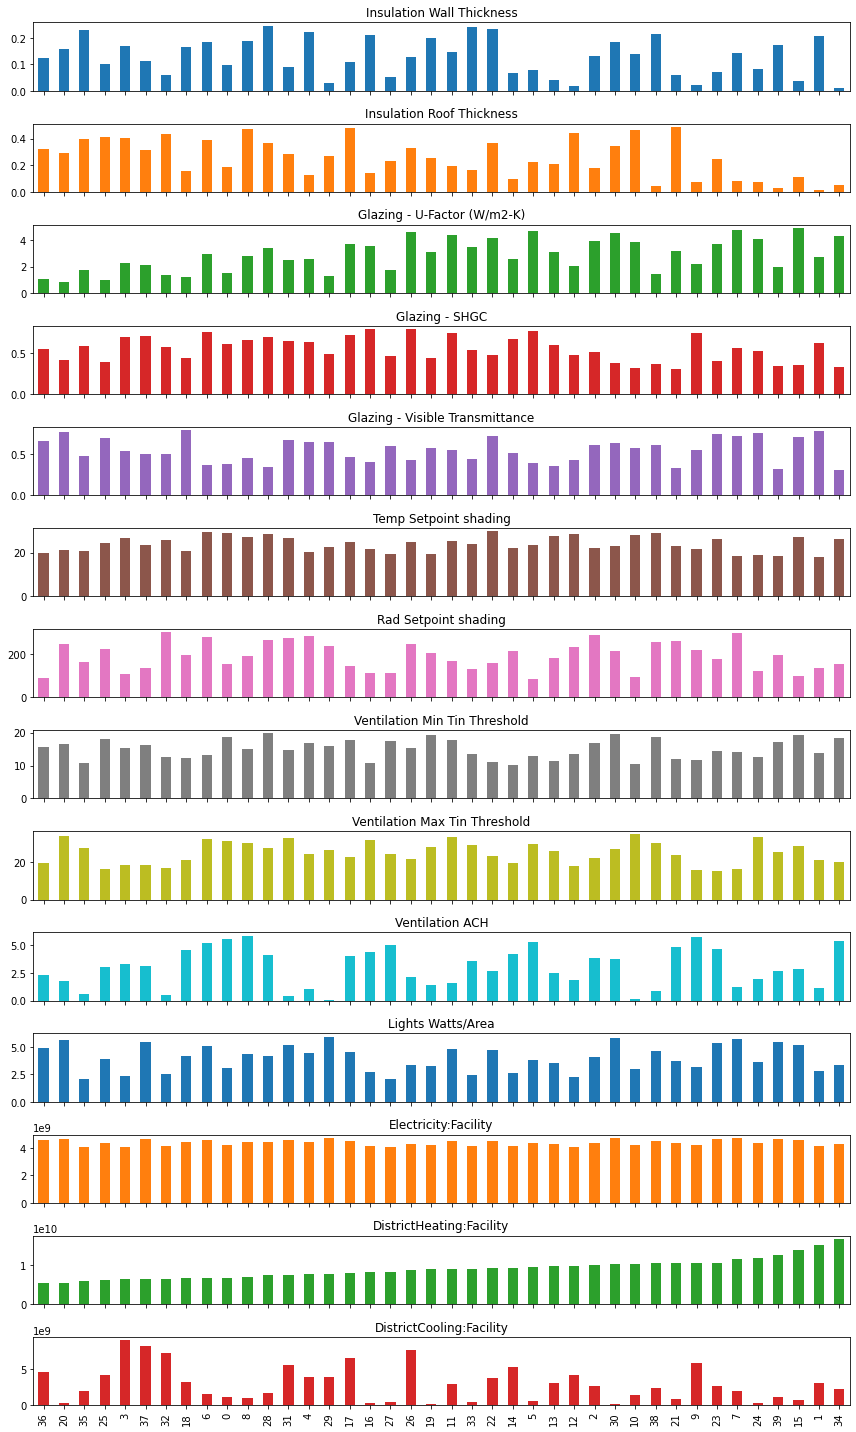

In [25]:
sim_samples = sim_samples.sort_values(by=objectives[1]) # sort by DistrictCooling:Facility
ax = sim_samples.plot.bar(subplots=True, legend=None, figsize=(12, 20))
plt.tight_layout()
plt.show()

## Visualising the parametric analysis

A better way to analyse the results is by looking at scatter plots of the inputs versus the outputs.  
This enables us to visually see strong relationships of inputs and outputs.


Generating plot part 1 with parameters: ['Insulation Wall Thickness', 'Insulation Roof Thickness', 'Glazing - U-Factor (W/m2-K)', 'Glazing - SHGC']


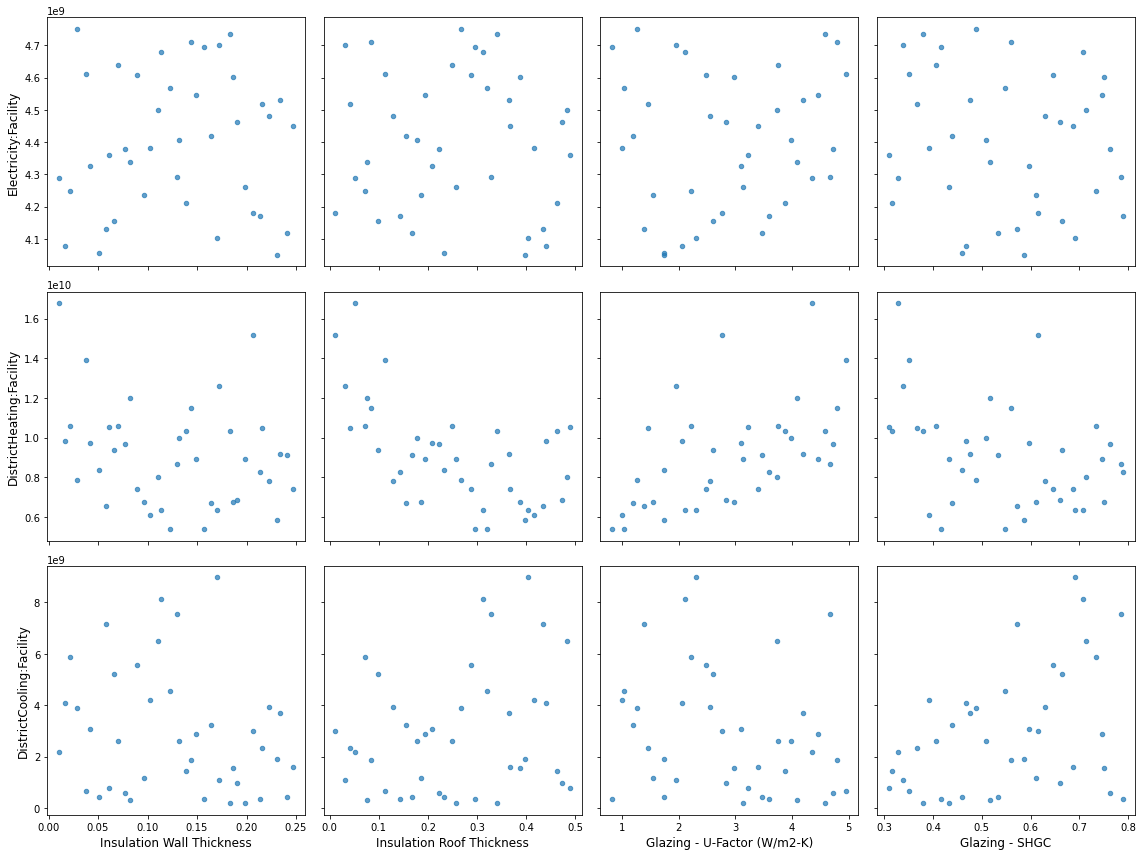


Generating plot part 2 with parameters: ['Glazing - Visible Transmittance', 'Temp Setpoint shading', 'Rad Setpoint shading', 'Ventilation Min Tin Threshold']


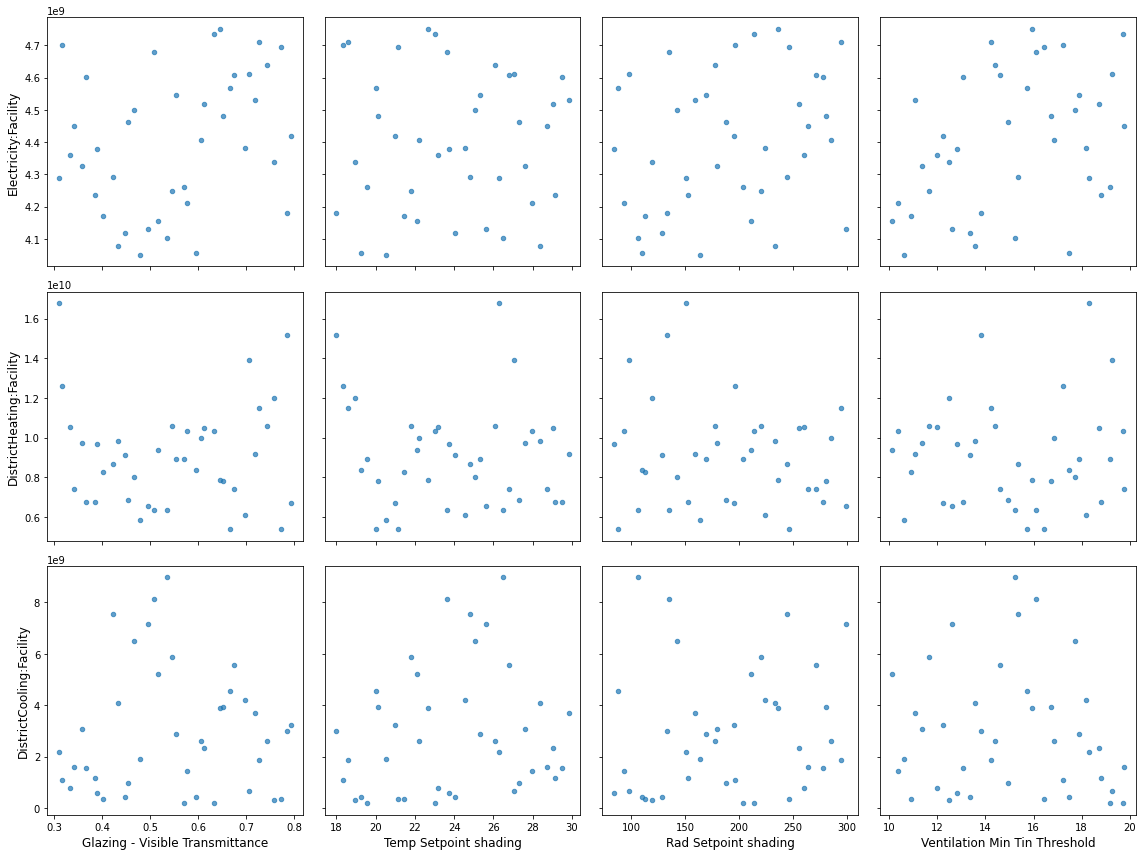


Generating plot part 3 with parameters: ['Ventilation Max Tin Threshold', 'Ventilation ACH', 'Lights Watts/Area']


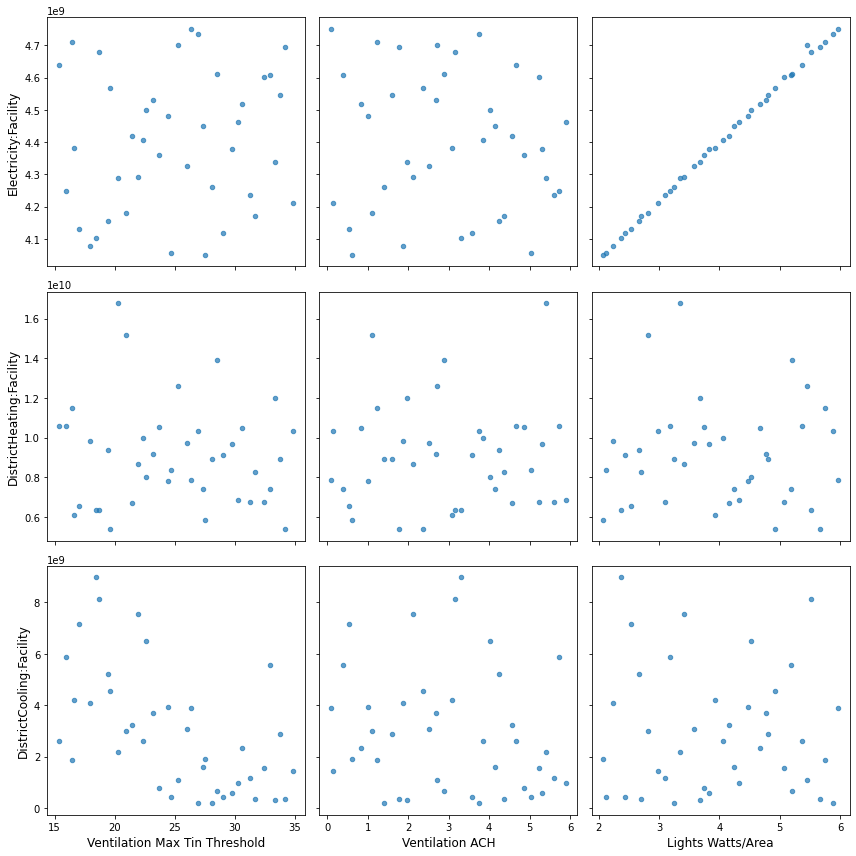

In [26]:
# Plot pairplot

# Get the list of all x-variables
all_x_vars = samples.columns.tolist()
num_x_vars = len(all_x_vars)
num_objectives = len(objectives)

def plot_pairgrid(samples, objectives, all_x_vars, cols_per_plot=4, unit_size=4):
    """Plot pairgrid of objectives vs parameters in chunks.

    Args:
        samples (DataFrame): DataFrame containing simulation samples.
        objectives (list): List of objective variable names.
        all_x_vars (list): List of all parameter variable names.
        cols_per_plot (int): Number of columns per plot grid.
        unit_size (int): Size of each plot unit in inches.

    Returns:
        None
    """
    # Loop through the x-variables, generating a new plot grid for each chunk
    for i in range(0, num_x_vars, cols_per_plot):
        current_x_vars = all_x_vars[i:i + cols_per_plot]
        current_cols = len(current_x_vars)
        
        print(f"\nGenerating plot part {i//cols_per_plot + 1} with parameters: {current_x_vars}")

        # Create the figure and the grid of axes (Rows = Objectives, Columns = current_x_vars)
        fig, axes = plt.subplots(
            num_objectives, 
            current_cols, 
            figsize=(current_cols * unit_size, num_objectives * unit_size)
        )

        # Ensure axes is always a 2D array
        if num_objectives == 1:
            axes = np.array([axes])
        if current_cols == 1:
            axes = np.array(axes).reshape(-1, 1)

        # Nested loops for plotting: Iterate over Objectives (Rows) and Parameters (Columns)
        for row in range(num_objectives):
            for col in range(current_cols):
                ax = axes[row, col]
                x_var = current_x_vars[col]
                y_var = objectives[row]

                # --- Scatter Plot ---
                ax.scatter(samples[x_var], samples[y_var], alpha=0.7, s=20)
                
                # --- Axis Labeling and Cleanup ---
                
                # Label the X-axis (Parameter name) only on the bottom row
                if row == num_objectives - 1:
                    ax.set_xlabel(x_var, fontsize=12)
                else:
                    ax.set_xticklabels([])
                
                # Label the Y-axis (Objective name) only on the first column
                if col == 0:
                    ax.set_ylabel(y_var, fontsize=12)
                else:
                    ax.set_yticklabels([])
        
        # Apply tight layout
        plt.tight_layout()
        plt.show()

plot_pairgrid(sim_samples, objectives, all_x_vars, cols_per_plot=4, unit_size=4)

### Correlation heat map
Another way to analyse the impact of the inputs on the outputs is by analysing the correlation.  
A common metric is the Pearsson correlation coefficient:

$ r = \frac{N\sum{XY}-(\sum{X}\sum{Y})}{\sqrt{ [N\sum{x^2}-(\sum{x})^2 ][N\sum{y^2}-(\sum{y})^2 }]} $

where N is the number of samples. $X$ is the vector of observation of variable 1 (e.g. wall conductivity) and $Y$ is the vetor of observations of variable 2 (e.g. electricity consumption).  
The closer $r$ is to one the stronger the correlation, and similarly for negative one and negative correleation.

To visualize the correlation coefficients of all inputs and outputs, we can plot a heatmap:

In [27]:
print("Columns in 'sim_samples':")
print(list(sim_samples.columns))

# Extract features
features = list(samples.columns)
print("Features extracted:")
print(features)

# Print objectives
print("Objectives:")
print(objectives)

Columns in 'sim_samples':
['Insulation Wall Thickness', 'Insulation Roof Thickness', 'Glazing - U-Factor (W/m2-K)', 'Glazing - SHGC', 'Glazing - Visible Transmittance', 'Temp Setpoint shading', 'Rad Setpoint shading', 'Ventilation Min Tin Threshold', 'Ventilation Max Tin Threshold', 'Ventilation ACH', 'Lights Watts/Area', 'Electricity:Facility', 'DistrictHeating:Facility', 'DistrictCooling:Facility']
Features extracted:
['Insulation Wall Thickness', 'Insulation Roof Thickness', 'Glazing - U-Factor (W/m2-K)', 'Glazing - SHGC', 'Glazing - Visible Transmittance', 'Temp Setpoint shading', 'Rad Setpoint shading', 'Ventilation Min Tin Threshold', 'Ventilation Max Tin Threshold', 'Ventilation ACH', 'Lights Watts/Area']
Objectives:
['Electricity:Facility', 'DistrictHeating:Facility', 'DistrictCooling:Facility']


In [28]:
corr = sim_samples.corr()
corr

Insulation Wall Thickness  \
Insulation Wall Thickness                         1.000000   
Insulation Roof Thickness                         0.029084   
Glazing - U-Factor (W/m2-K)                       0.027941   
Glazing - SHGC                                    0.151029   
Glazing - Visible Transmittance                   0.071167   
Temp Setpoint shading                            -0.070346   
Rad Setpoint shading                              0.045108   
Ventilation Min Tin Threshold                     0.064089   
Ventilation Max Tin Threshold                     0.321125   
Ventilation ACH                                  -0.159112   
Lights Watts/Area                                 0.057549   
Electricity:Facility                              0.058422   
DistrictHeating:Facility                         -0.248856   
DistrictCooling:Facility                         -0.215148   

                                 Insulation Roof Thickness  \
Insulation Wall Thickness                         0.029084   
Insulation Roof Thickness                         1.000000   
Glazing - U-Factor (W/m2-K)                      -0.114986   
Glazing - SHGC                                    0.048402   
Glazing - Visible Transmittance                  -0.197942   
Temp Setpoint shading                             0.416849   
Rad Setpoint shading                              0.082279   
Ventilation Min Tin Threshold                    -0.087879   
Ventilation Max Tin Threshold                    -0.008899   
Ventilation ACH                                  -0.014221   
Lights Watts/Area                                -0.057209   
Electricity:Facility                             -0.059773   
DistrictHeating:Facility                         -0.579145   
DistrictCooling:Facility                          0.233972   

                                 Glazing - U-Factor (W/m2-K)  Glazing - SHGC  \
Insulation Wall Thickness                           0.027941        0.151029   
Insulation Roof Thickness                          -0.114986        0.048402   
Glazing - U-Factor (W/m2-K)                         1.000000        0.107479   
Glazing - SHGC                                      0.107479        1.000000   
Glazing - Visible Transmittance                    -0.117279       -0.270767   
Temp Setpoint shading                               0.136802        0.051795   
Rad Setpoint shading                               -0.168217       -0.024288   
Ventilation Min Tin Threshold                      -0.001870       -0.212440   
Ventilation Max Tin Threshold                       0.145753        0.030330   
Ventilation ACH                                     0.150938        0.165210   
Lights Watts/Area                                   0.105352       -0.155144   
Electricity:Facility                                0.105762       -0.153904   
DistrictHeating:Facility                            0.550114       -0.369689   
DistrictCooling:Facility                           -0.236535        0.413667   

                                 Glazing - Visible Transmittance  \
Insulation Wall Thickness                               0.071167   
Insulation Roof Thickness                              -0.197942   
Glazing - U-Factor (W/m2-K)                            -0.117279   
Glazing - SHGC                                         -0.270767   
Glazing - Visible Transmittance                         1.000000   
Temp Setpoint shading                                  -0.323699   
Rad Setpoint shading                                   -0.002472   
Ventilation Min Tin Threshold                           0.031893   
Ventilation Max Tin Threshold                          -0.102846   
Ventilation ACH                                        -0.395056   
Lights Watts/Area                                       0.325611   
Electricity:Facility                                    0.298066   
DistrictHeating:Facility                               -0.007527   
DistrictCooling:Fa

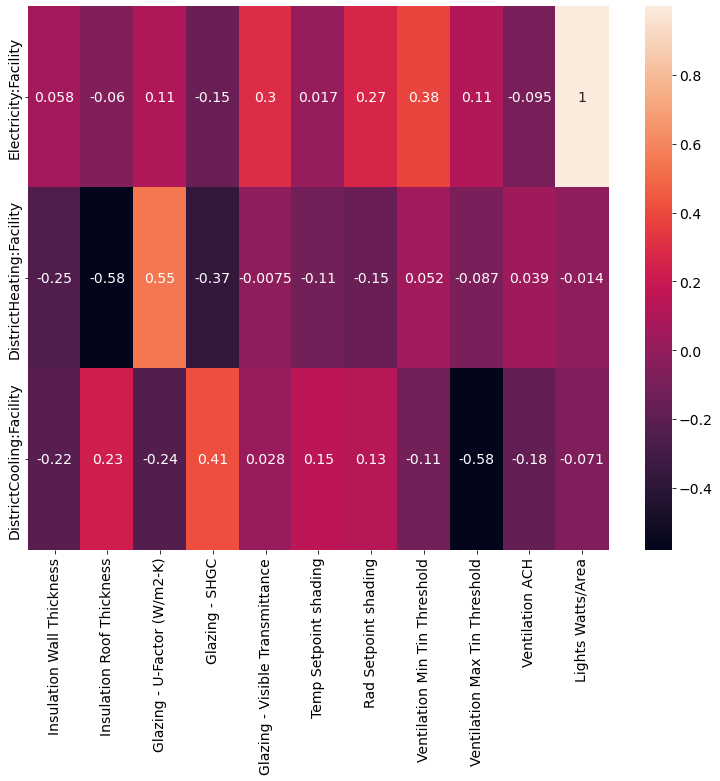

In [29]:
corr.drop(objectives, axis=1, inplace=True)      
corr.drop(features, axis=0, inplace=True)   

plt.rcParams.update({'font.size': 14})
plt.figure(figsize=(13, 10)) 

_ = heatmap(corr, annot=True)

# Setup the dataset for the Surrogate Model

In [30]:
y = sim_samples[objectives]
x = sim_samples.drop(columns=objectives)

## Train-test split

Next we split the data into a training set (80%) and a testing set (20%).

In [31]:
train_in, test_in, train_out, test_out = train_test_split(x, y, test_size=0.2)

## Normalization of inputs

To ensure an equal weighting of inputs and outputs in the backpropagation algorithm fitting the neural network, we have to normalize the input values.
For example window-to-wall ratio is in the range of 0 to 1 while the W/$m^2$ are in a range of 10 to 15.
Different options for normalization exist.
Here we bring all features (input variables) to have zero mean and a standarddeviation of 1.
Note that we fit the normalizer on training data only.

In [32]:
scaler = StandardScaler()
train_in_scale = scaler.fit_transform(X=train_in)
test_in_scale = scaler.fit_transform(X=test_in)

scaler_out = StandardScaler()
train_out_scale = scaler_out.fit_transform(X=train_out)
test_out_scale = scaler_out.fit_transform(X=test_out)

# Neural Network

## Hyper-parameters

Before we start fitting the NN model we define the set of hyperparameters we want to analyse in our cross-validation to optimize the model.
Here, we select the number of layers of the network as well as the regularization parameter alpha as parameter value.
A larger number of layers and a lower value of the regularizer lead to higher variance of the network.
This may lead to overfitting.
The best selection may be found using an optimizer like Bayesian Optimization.
In this example we use a simple grid search.

In [33]:
hyperparameters = {
    "hidden_layer_sizes": (
        (len(parameters) * 16,),
        (len(parameters) * 16, len(parameters) * 16),
    ),
    "alpha": [1, 10, 10 ** 3],
}

neural_net = MLPRegressor(max_iter=1000, early_stopping=False)
folds = 3

## Model fitting

Here, we use the NN model from ScikitLearn.


In [34]:
clf = GridSearchCV(neural_net, hyperparameters, cv=folds)
clf.fit(train_in_scale, train_out_scale)

nn_model = clf.best_estimator_

print("Best Hyperparameters Found:")
print(clf.best_params_)

Best Hyperparameters Found:
{'alpha': 1, 'hidden_layer_sizes': (176,)}


In [35]:
prediction_nn_scaled = nn_model.predict(test_in_scale)
prediction_nn = scaler_out.inverse_transform(prediction_nn_scaled)
print("Predictions:", prediction_nn)

Predictions: [[4.23600647e+09 8.88180928e+09 3.00950702e+09]
 [4.53721460e+09 1.00391014e+10 1.98375028e+09]
 [4.55449395e+09 1.02073275e+10 2.58900665e+09]
 [4.31053079e+09 9.99248255e+09 4.83903042e+09]
 [4.56141033e+09 6.89462976e+09 2.31924344e+09]
 [4.36141804e+09 1.20067218e+10 2.02818734e+09]
 [4.45287147e+09 6.08712267e+09 1.54784447e+09]
 [4.31143414e+09 1.20422029e+10 3.08180634e+09]]


In [36]:
print("Model NRMSE:")
nrmse = mean_squared_error(prediction_nn, test_out.values, multioutput='raw_values', squared=False) / test_out.mean() * 100
print(nrmse)

print("\nModel R2 SCORE:")
r2 = r2_score(test_out.values, prediction_nn, multioutput='raw_values')
print(r2)

Model NRMSE:
Electricity:Facility         0.617117
DistrictHeating:Facility    28.024397
DistrictCooling:Facility    44.560602
dtype: float64

Model R2 SCORE:
[ 0.95966986 -0.15244858  0.59660614]


## Surrogate Modelling Evaluator object
We can wrap the fitted model in a BESOS `Evaluator`.

In [37]:
# Definition of the evaluation function
def evaluation_func(ind, scaler=scaler):
    # Scale the input using the scaler
    ind = scaler.transform(X=[ind])
    # Predict using the model
    prediction = nn_model.predict(ind)
    # Inverse scale and return as a list
    return scaler_out.inverse_transform(prediction)[0].tolist()

evaluator = EvaluatorGeneric(evaluation_func, problem)

srinputs = sampling.dist_sampler(sampling.lhs, problem, 500)
srinputs

Insulation Wall Thickness  Insulation Roof Thickness  \
0                     0.047768                   0.431449   
1                     0.127265                   0.261490   
2                     0.195350                   0.042576   
3                     0.230197                   0.180606   
4                     0.042797                   0.395969   
..                         ...                        ...   
495                   0.243943                   0.180165   
496                   0.054706                   0.445789   
497                   0.148611                   0.137721   
498                   0.232729                   0.326899   
499                   0.151754                   0.332316   

     Glazing - U-Factor (W/m2-K)  Glazing - SHGC  \
0                       1.015469        0.348648   
1                       1.496065        0.457469   
2                       3.652145        0.798414   
3                       2.842524        0.318383   
4                       1.734577        0.664710   
..                           ...             ...   
495                     1.062878        0.414340   
496                     4.063604        0.403559   
497                     0.924782        0.408747   
498                     1.985047        0.449004   
499                     2.433049        0.420248   

     Glazing - Visible Transmittance  Temp Setpoint shading  \
0                           0.613850              20.279252   
1                           0.583536              21.586236   
2                           0.724270              25.939171   
3                           0.726553              26.507480   
4                           0.474868              20.952150   
..                               ...                    ...   
495                         0.424432              23.185592   
496                         0.591703              18.743956   
497                         0.535905              22.737654   
498                         0.525719              25.526718   
499                         0.698164              19.619868   

     Rad Setpoint shading  Ventilation Min Tin Threshold  \
0              108.279872                      11.744424   
1              183.543038                      13.495873   
2               87.158031                      13.082167   
3              234.055414                      18.819403   
4              283.237230                      19.701372   
..                    ...                            ...   
495            179.302757                      17.504280   
496            269.103037                      13.452172   
497            129.546595                      12.787810   
498            216.277174                      18.516487   
499            231.733407                      14.312907   

     Ventilation Max Tin Threshold  Ventilation ACH  Lights Watts/Area  
0                        20.697110         0.190260           5.584161  
1                        20.727119         2.216621           3.810095  
2                        29.390766         0.983691           5.722675  
3                        15.142583         1.696160           2.587791  
4                        34.540788         1.640442           4.082801  
..                             ...              ...                ...  
495                      20.304901         5.030139           5.972501  
496                      25.692476         1.203406           3.683641  
497                      32.221084         5.863408           4.655692  
498                      15.648764         3.392034           2.316474  
499                      26.912147         5.603299           2.448149  

[500 rows x 11 columns]

In [38]:
sroutputs = evaluator.df_apply(srinputs)
srresults = srinputs.join(sroutputs)
srresults.head()

Executing:   0%|          | 0/500 [00:00<?, ?row/s]

/opt/conda/envs/myenv/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/opt/conda/envs/myenv/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/opt/conda/envs/myenv/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/opt/conda/envs/myenv/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/opt/conda/envs/myenv/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/opt/conda/envs/myenv/lib/python3.9/site-packages/sklearn/base.py

Insulation Wall Thickness  Insulation Roof Thickness  \
0                   0.047768                   0.431449   
1                   0.127265                   0.261490   
2                   0.195350                   0.042576   
3                   0.230197                   0.180606   
4                   0.042797                   0.395969   

   Glazing - U-Factor (W/m2-K)  Glazing - SHGC  \
0                     1.015469        0.348648   
1                     1.496065        0.457469   
2                     3.652145        0.798414   
3                     2.842524        0.318383   
4                     1.734577        0.664710   

   Glazing - Visible Transmittance  Temp Setpoint shading  \
0                         0.613850              20.279252   
1                         0.583536              21.586236   
2                         0.724270              25.939171   
3                         0.726553              26.507480   
4                         0.474868              20.952150   

   Rad Setpoint shading  Ventilation Min Tin Threshold  \
0            108.279872                      11.744424   
1            183.543038                      13.495873   
2             87.158031                      13.082167   
3            234.055414                      18.819403   
4            283.237230                      19.701372   

   Ventilation Max Tin Threshold  Ventilation ACH  Lights Watts/Area  \
0                      20.697110         0.190260           5.584161   
1                      20.727119         2.216621           3.810095   
2                      29.390766         0.983691           5.722675   
3                      15.142583         1.696160           2.587791   
4                      34.540788         1.640442           4.082801   

   Electricity:Facility  DistrictHeating:Facility  DistrictCooling:Facility  
0          4.687574e+09              8.030086e+09              1.520240e+09  
1          4.372807e+09              7.890582e+09              2.341741e+09  
2          4.696767e+09              9.004169e+09              5.097504e+09  
3          4.251422e+09              1.056613e+10              2.101168e+09  
4          4.419726e+09              5.633299e+09              9.659044e+08

## Exploration

In [39]:
plotly.offline.init_notebook_mode(connected=True)

In [40]:
fig = px.parallel_coordinates(
    srresults, color="Electricity:Facility",
    dimensions=features + objectives,
    color_continuous_scale=px.colors.diverging.Tealrose
)

fig.update_layout(
    width=1300,
    height=600,
    margin=dict(l=80, r=80, t=50, b=50)
)

fig.show()

# Perform Building Optimization 

Using the best surrogate perform an otimization process, select optimal values and save a new idf with the selected values. Evalute the goodnes of the surrogate simuation with EnergyPlus.

In [41]:
# Running NSGA-II optimizator 
results = NSGAII(evaluator, evaluations=5000, population_size=10000)

opt_res = results.loc[results["pareto-optimal"] == True, :]  # Get only the optimal results
opt_res

/opt/conda/envs/myenv/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names

/opt/conda/envs/myenv/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names

/opt/conda/envs/myenv/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names

/opt/conda/envs/myenv/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names

/opt/conda/envs/myenv/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names

/opt/conda/envs/myenv/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but StandardScaler

Insulation Wall Thickness  Insulation Roof Thickness  \
161                    0.204930                   0.497630   
370                    0.063869                   0.437408   
600                    0.182887                   0.345772   
1277                   0.156683                   0.172391   
1285                   0.183970                   0.447624   
1317                   0.220902                   0.486300   
1430                   0.209225                   0.147030   
1856                   0.204193                   0.274071   
1917                   0.213412                   0.315471   
1937                   0.168549                   0.195899   
2429                   0.129632                   0.221654   
2450                   0.190755                   0.399648   
2847                   0.165189                   0.317095   
2926                   0.178247                   0.433387   
3162                   0.189221                   0.405126   
3220                   0.185428                   0.353876   
3484                   0.191730                   0.289917   
3583                   0.172366                   0.480522   
3629                   0.116883                   0.348840   
3670                   0.191007                   0.460782   
3923                   0.185953                   0.206460   
4143                   0.220247                   0.396585   
4585                   0.232326                   0.464976   
4598                   0.034657                   0.299983   
4664                   0.222646                   0.460447   
5088                   0.178445                   0.451828   
5105                   0.215185                   0.433284   
5257                   0.167151                   0.449383   
5329                   0.107804                   0.376634   
5477                   0.217257                   0.327477   
5818                   0.143606                   0.363870   
5871                   0.157988                   0.482399   
6098                   0.027219                   0.184814   
6118                   0.249890                   0.234926   
6254                   0.121959                   0.418260   
6280                   0.117945                   0.412276   
6324                   0.202709                   0.422355   
6605                   0.049089                   0.488333   
7333                   0.207530                   0.415165   
7381                   0.153991                   0.461280   
7389                   0.152927                   0.449466   
7599                   0.035618                   0.184737   
7735                   0.208168                   0.476558   
7756                   0.158246                   0.422043   
7943                   0.167615                   0.354379   
8458                   0.176707                   0.257998   
8621                   0.186639                   0.328089   
8863                   0.231774                   0.411995   
8971                   0.237747                   0.395470   
9047                   0.166268                   0.470670   
9266                   0.194495                   0.435554   
9590                   0.229194                   0.244245   
9614                   0.138206                   0.401196   
9655                   0.062891                   0.302717   
9757                   0.232811                   0.321417   
9885                   0.181831                   0.382409   

      Glazing - U-Factor (W/m2-K)  Glazing - SHGC  \
161                      1.375112        0.766268   
370                      0.836817        0.603033   
600                      2.427709        0.512511   
1277                     0.885214        0.386468   
1285                     1.165182        0.647457   
1317                     1.062496        0.614176   
1430                     1.041775        0.715239   
1856                     0.934793        0.3267

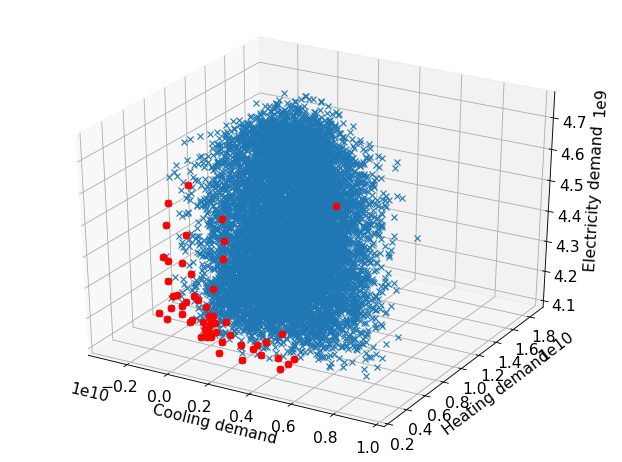

In [42]:
# Plot the results
plt.figure(figsize=(8, 6), dpi=80)
ax = plt.axes(projection='3d')

df = pd.DataFrame(opt_res, columns=features + objectives)

ax.plot3D(
    results["DistrictCooling:Facility"],
    results["DistrictHeating:Facility"],
    results["Electricity:Facility"], "x"
)  # plot all results in the background as blue crosses

ax.plot3D(
    opt_res["DistrictCooling:Facility"],
    opt_res["DistrictHeating:Facility"],
    opt_res["Electricity:Facility"],
    "ro"
)  # plot optimal results in red

ax.set_xlabel("Cooling demand")
ax.set_ylabel("Heating demand")
ax.set_zlabel("Electricity demand")
plt.tight_layout()
plt.show()


Generating plot part 1 with parameters: ['Insulation Wall Thickness', 'Insulation Roof Thickness', 'Glazing - U-Factor (W/m2-K)', 'Glazing - SHGC']


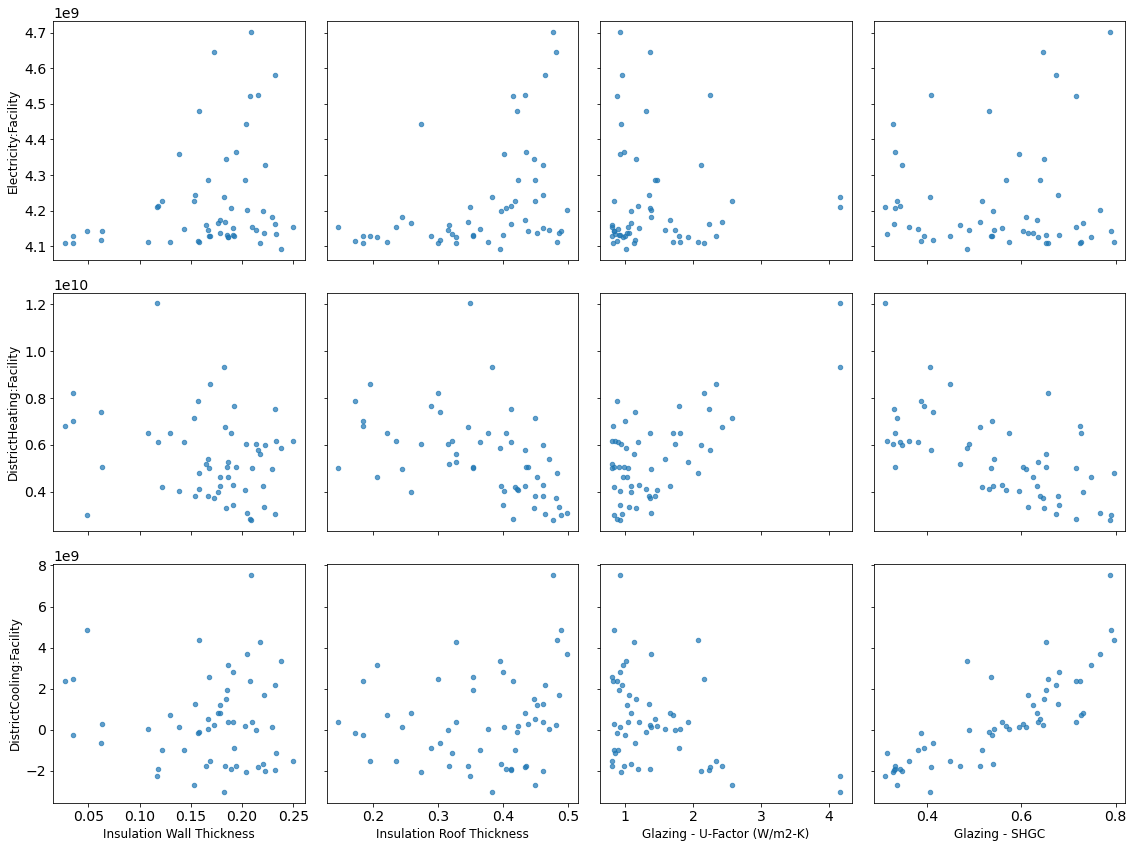


Generating plot part 2 with parameters: ['Glazing - Visible Transmittance', 'Temp Setpoint shading', 'Rad Setpoint shading', 'Ventilation Min Tin Threshold']


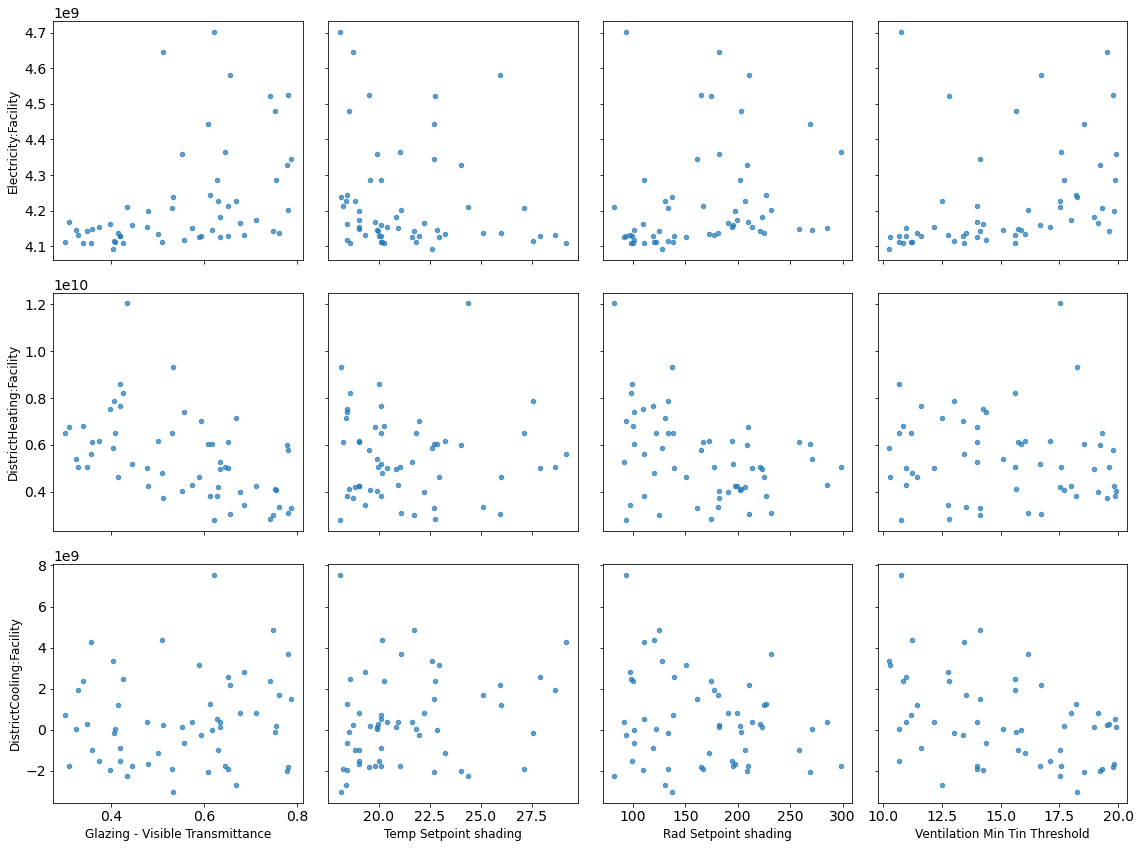


Generating plot part 3 with parameters: ['Ventilation Max Tin Threshold', 'Ventilation ACH', 'Lights Watts/Area']


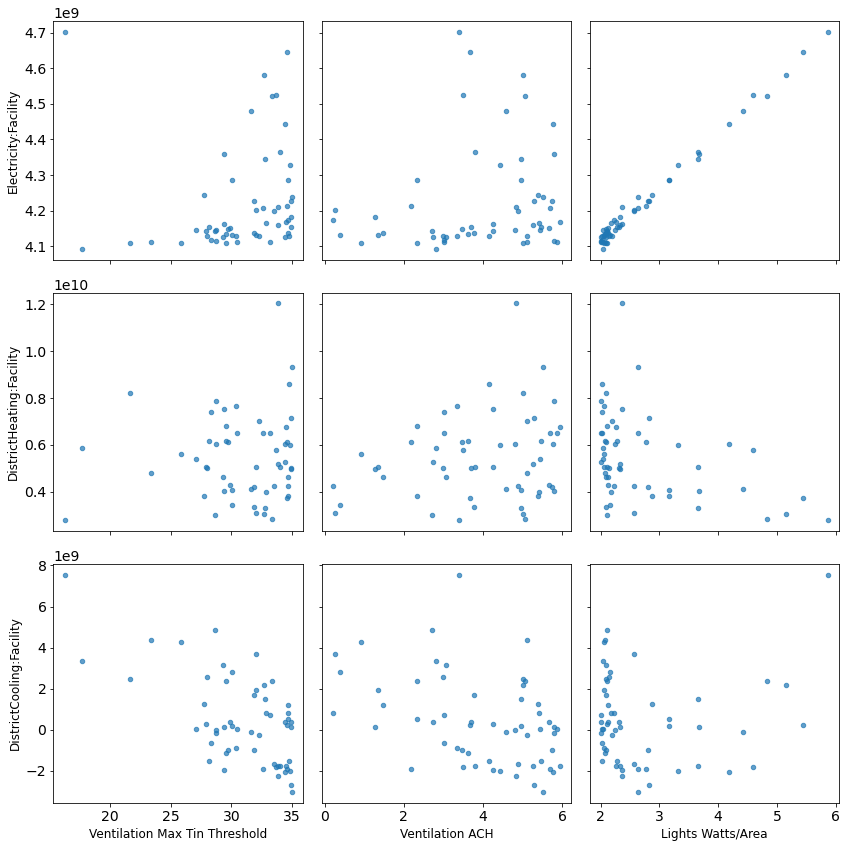

In [43]:
# Plot pairplot of the optimal results
plot_pairgrid(opt_res, objectives, all_x_vars, cols_per_plot=4, unit_size=4)

In [44]:
# Compute the correlation matrix
corr = opt_res.corr()

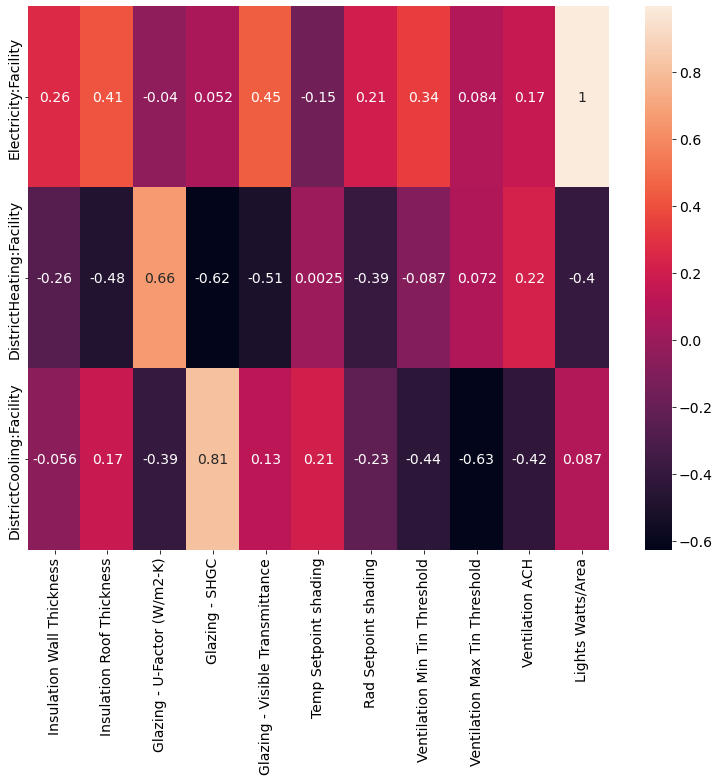

In [45]:
# Variables to exclude from the correlation heatmap
unuseful = ['violation', 'pareto-optimal']

# Drop unwanted objectives and features from the correlation matrix
corr.drop(objectives + unuseful, axis = 1, inplace = True)
corr.drop(features + unuseful, axis = 0 ,inplace = True)
corr

# Plotting the refined correlation heatmap
plt.figure(figsize=(13, 10))
_ = heatmap(corr, annot=True)

Select the optimal parameters and outputs

In [58]:
def calculate_total_primary_energy(simulation_outputs):
    """
    Calculates the total primary energy from simulation outputs.
    
    Args:
        simulation_outputs (dict): A dictionary containing the simulation outputs.
    
    Returns:
        float: Total primary energy.
    """
    # Get NET ENERGY from simulation outputs
    Q_H_net = abs(simulation_outputs['DistrictHeating:Facility'])
    Q_C_net = abs(simulation_outputs['DistrictCooling:Facility'])
    Q_light_net = abs(simulation_outputs['Electricity:Facility'])
    
    # Conversion: NET to FINAL ENERGY (Q_final)
    # ASSUME: Heating is Gas Boiler (COP=0.98), Cooling is split-electric (EER=5.4), Lighting is Electric
    # - Heating Final
    COP_H = 0.98  
    Q_H_final = Q_H_net / COP_H
    
    # - Cooling Final
    EER_C = 5.4  
    Q_C_final = Q_C_net / EER_C
    
    # - Lighting Final
    Q_light_final = Q_light_net
    
    # Conversion: FINAL to PRIMARY ENERGY (Q_PE)
    # PE Factors based on source
    PE_gas = 1.00
    PE_electricity = 2.17
    # - Heating Primary
    Q_H_PE = Q_H_final * PE_gas
    # - Cooling Primary
    Q_C_PE = Q_C_final * PE_electricity
    # - Lighting Primary
    Q_light_PE = Q_light_final * PE_electricity
    
    # Total PRIMARY ENERGY
    Q_total_PE = Q_H_PE + Q_C_PE + Q_light_PE
    
    return Q_total_PE

# Compute the total Primary Energy for every row
df['Q_Total_PE'] = df.apply(calculate_total_primary_energy, axis=1)

# Find the index that corresponds to the minimum Primary Energy value
min_pe_index = df['Q_Total_PE'].idxmin()

# Extract the optimal row
optimal_row = df.loc[min_pe_index]

print("Optimal Values:")
print(optimal_row)

Optimal Values:
Insulation Wall Thickness          2.209022e-01
Insulation Roof Thickness          4.863005e-01
Glazing - U-Factor (W/m2-K)        1.062496e+00
Glazing - SHGC                     6.141759e-01
Glazing - Visible Transmittance    7.620033e-01
Temp Setpoint shading              2.508514e+01
Rad Setpoint shading               1.809632e+02
Ventilation Min Tin Threshold      1.352309e+01
Ventilation Max Tin Threshold      3.181905e+01
Ventilation ACH                    3.784120e+00
Lights Watts/Area                  2.090240e+00
Electricity:Facility               4.138290e+09
DistrictHeating:Facility           3.358961e+09
DistrictCooling:Facility           1.688438e+09
Q_Total_PE                         1.308610e+10
Name: 1317, dtype: float64


Identify best building design parameters and save the new idf

In [59]:
optimal_params = optimal_row[features].to_dict()
optimal_outputs = optimal_row[objectives].to_dict()
optimal_total_pe = optimal_row['Q_Total_PE']

print("Optimal Parameters:", optimal_params)
print("Optimal Outputs:", optimal_outputs)
print("Total primary energy of the optimal solution:", optimal_total_pe)

Optimal Parameters: {'Insulation Wall Thickness': 0.22090222993935804, 'Insulation Roof Thickness': 0.4863004642327592, 'Glazing - U-Factor (W/m2-K)': 1.0624957101925012, 'Glazing - SHGC': 0.6141758602042744, 'Glazing - Visible Transmittance': 0.7620032882158385, 'Temp Setpoint shading': 25.085139968476774, 'Rad Setpoint shading': 180.96321537296927, 'Ventilation Min Tin Threshold': 13.52309226704876, 'Ventilation Max Tin Threshold': 31.81905134068813, 'Ventilation ACH': 3.7841195969078463, 'Lights Watts/Area': 2.090240273469487}
Optimal Outputs: {'Electricity:Facility': 4138289919.3174872, 'DistrictHeating:Facility': 3358960869.2241745, 'DistrictCooling:Facility': 1688437620.3970325}
Total primary energy of the optimal solution: 13086102000.456905


In [60]:
# Selection of the optimal parameters
insulation_wall_selector.set(building, optimal_params['Insulation Wall Thickness'])
insulation_roof_selector.set(building, optimal_params['Insulation Roof Thickness'])
u_factor_selector.set(building, optimal_params['Glazing - U-Factor (W/m2-K)'])
shgc_selector.set(building, optimal_params['Glazing - SHGC'])
visible_transmittance_selector.set(building, optimal_params['Glazing - Visible Transmittance'])
shade_temp_selector.set(building, optimal_params['Temp Setpoint shading'])
shade_rad_selector.set(building, optimal_params['Rad Setpoint shading'])
vent_tin_min_selector.set(building, optimal_params['Ventilation Min Tin Threshold'])
vent_tin_max_selector.set(building, optimal_params['Ventilation Max Tin Threshold'])
ventACH_selector.set(building, optimal_params['Ventilation ACH'])
lights_selector.set(building, optimal_params['Lights Watts/Area'])

In [61]:
# Save the optimised building to a new IDF file
building.saveas('res2_optimal.idf')

In [62]:
building.idfobjects['MATERIAL']

[
Material,
    Cast Concrete (Dense)_.1,    !- Name
    Rough,                    !- Roughness
    0.1,                      !- Thickness
    1.4,                      !- Conductivity
    2100,                     !- Density
    840,                      !- Specific Heat
    0.9,                      !- Thermal Absorptance
    0.6,                      !- Solar Absorptance
    0.6;                      !- Visible Absorptance
, 
Material,
    Asphalt 1_.01,            !- Name
    Rough,                    !- Roughness
    0.01,                     !- Thickness
    0.7,                      !- Conductivity
    2100,                     !- Density
    1000,                     !- Specific Heat
    0.9,                      !- Thermal Absorptance
    0.85,                     !- Solar Absorptance
    0.9;                      !- Visible Absorptance
, 
Material,
    MW Glass Wool (rolls)_.0001,    !- Name
    Rough,                    !- Roughness
    0.4863004642327592,       !- Thickness

Plot the optimal parameters

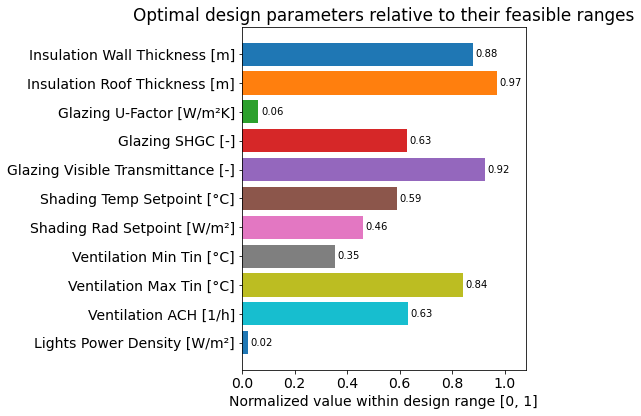

In [63]:
# Parameter keys
param_keys = [
    'Insulation Wall Thickness',
    'Insulation Roof Thickness',
    'Glazing - U-Factor (W/m2-K)',
    'Glazing - SHGC',
    'Glazing - Visible Transmittance',
    'Temp Setpoint shading',
    'Rad Setpoint shading',
    'Ventilation Min Tin Threshold',
    'Ventilation Max Tin Threshold',
    'Ventilation ACH',
    'Lights Watts/Area',
]

# Parameter labels
param_labels = [
    "Insulation Wall Thickness [m]",
    "Insulation Roof Thickness [m]",
    "Glazing U-Factor [W/m²K]",
    "Glazing SHGC [-]",
    "Glazing Visible Transmittance [-]",
    "Shading Temp Setpoint [°C]",
    "Shading Rad Setpoint [W/m²]",
    "Ventilation Min Tin [°C]",
    "Ventilation Max Tin [°C]",
    "Ventilation ACH [1/h]",
    "Lights Power Density [W/m²]",
]

# Parameter ranges
param_bounds = {
    'Insulation Wall Thickness': (0.01, 0.25),
    'Insulation Roof Thickness': (0.01, 0.50),
    'Glazing - U-Factor (W/m2-K)': (0.8, 5.0),
    'Glazing - SHGC': (0.3, 0.8),
    'Glazing - Visible Transmittance': (0.3, 0.8),
    'Temp Setpoint shading': (18.0, 30.0),
    'Rad Setpoint shading': (80.0, 300.0),
    'Ventilation Min Tin Threshold': (10.0, 20.0),
    'Ventilation Max Tin Threshold': (15.0, 35.0),
    'Ventilation ACH': (0.0, 6.0),
    'Lights Watts/Area': (2.0, 6.0),
}

# Extract and normalize the optimal values
norm_vals = []
for key in param_keys:
    p_min, p_max = param_bounds[key]
    v = optimal_params[key]
    norm_vals.append((v - p_min) / (p_max - p_min))

# Define a list of colors
colors = plt.cm.tab10.colors[:len(param_keys)]

# Create horizontal bar chart
fig, ax = plt.subplots(figsize=(8, 6))
y_pos = np.arange(len(param_labels))
ax.barh(y_pos, norm_vals, color=colors)

# Add values at the left of the bars
for i, v in enumerate(norm_vals):
    ax.text(v + 0.01, i, f'{v:.2f}', color='black', va='center', fontsize=10)

ax.set_yticks(y_pos)
ax.set_yticklabels(param_labels)
ax.invert_yaxis()
ax.set_xlim(0, 1.08) # Add some space on the right for text
ax.set_xlabel("Normalized value within design range [0, 1]")
ax.set_title("Optimal design parameters relative to their feasible ranges")
plt.tight_layout()
plt.show()

Plot the optimal outputs and primary energy

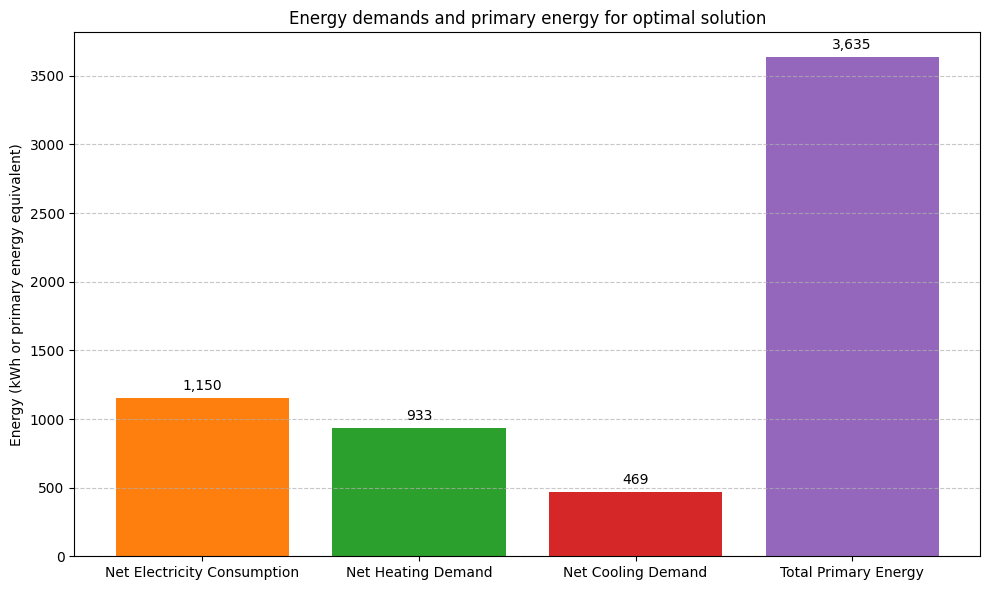

In [ ]:
# --- Data preparation ---
energy_values = [
    optimal_outputs['Electricity:Facility'],
    optimal_outputs['DistrictHeating:Facility'], 
    optimal_outputs['DistrictCooling:Facility'],
    optimal_total_pe
]
energy_labels = [
    'Net Electricity Consumption',
    'Net Heating Demand', 
    'Net Cooling Demand',
    'Total Primary Energy'
]

# Convert Joules to kWh
J_TO_KWH = 3.6e+6
plot_values_kwh = [v / J_TO_KWH for v in energy_values]

# Define a list of colors
colors = plt.cm.tab10.colors[1:len(plot_values_kwh) + 1]

# --- Plot ---
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(energy_labels, plot_values_kwh, color=colors)

# Add values on top of the bars
for bar in bars:
    yval = bar.get_height()
    offset = max(plot_values_kwh) * 0.01 if plot_values_kwh else 10
    ax.text(bar.get_x() + bar.get_width() / 2.0, yval + offset, 
            f'{yval:,.0f}', ha='center', va='bottom', fontsize=10)

ax.set_title('Energy demands and primary energy for optimal solution')
ax.set_ylabel('Energy (kWh or primary energy equivalent)')
ax.set_xticks(np.arange(len(energy_labels)))
ax.set_xticklabels(energy_labels)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()